In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import ceil

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
SEED = 25


In [12]:
df = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\classification_dataset.csv')
df['class'] = round(df['class'] / 10).astype(int)
_type = df['type'].to_list()
df = df.drop(['name', 'side_mistake',
              'vs', 'squared_vs', 'ttr', 'root_ttr',
              'log_ttr', 'uber_ttr', 'd', 'vvi',
              'squared_vv', 'punct_mistakes_pp',
              'punct_mistakes_because',
              'punct_mistakes_but', 'punct_mistakes_compare'], axis=1)

df.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_linkings,num_4grams,num_func_ngrams,num_shell_noun,num_misspelled_tokens,million_mistake,text,class,type,sum_punct
0,3.56,6,2,2,0,1,18,244,4.39,13.56,...,5,1,0,0,2,0,This two line graphs illustrates monthly avera...,6,1,0
1,5.43,10,4,1,3,1,7,175,6.29,25.00,...,6,1,0,0,3,0,"﻿We have two graphics, which show us the popul...",6,1,0


In [13]:
df.shape

(3441, 62)

In [14]:
df['class'].value_counts()

6    2680
7     308
5     215
4     122
8      77
2      24
3      14
1       1
Name: class, dtype: int64

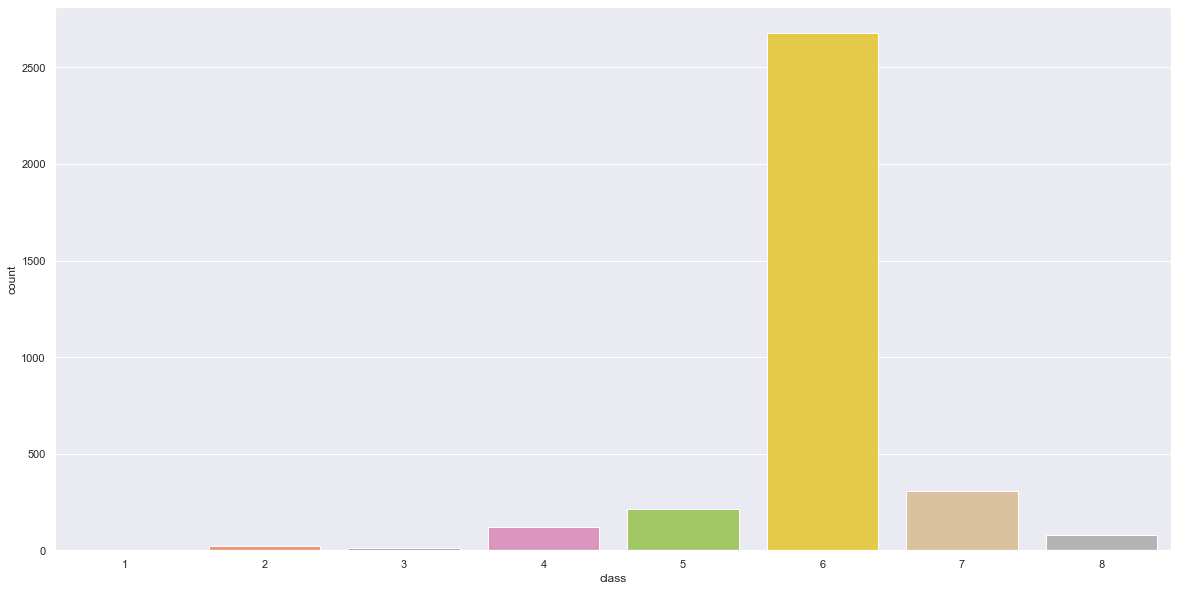

In [15]:
sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='class', data=df, palette="Set2")

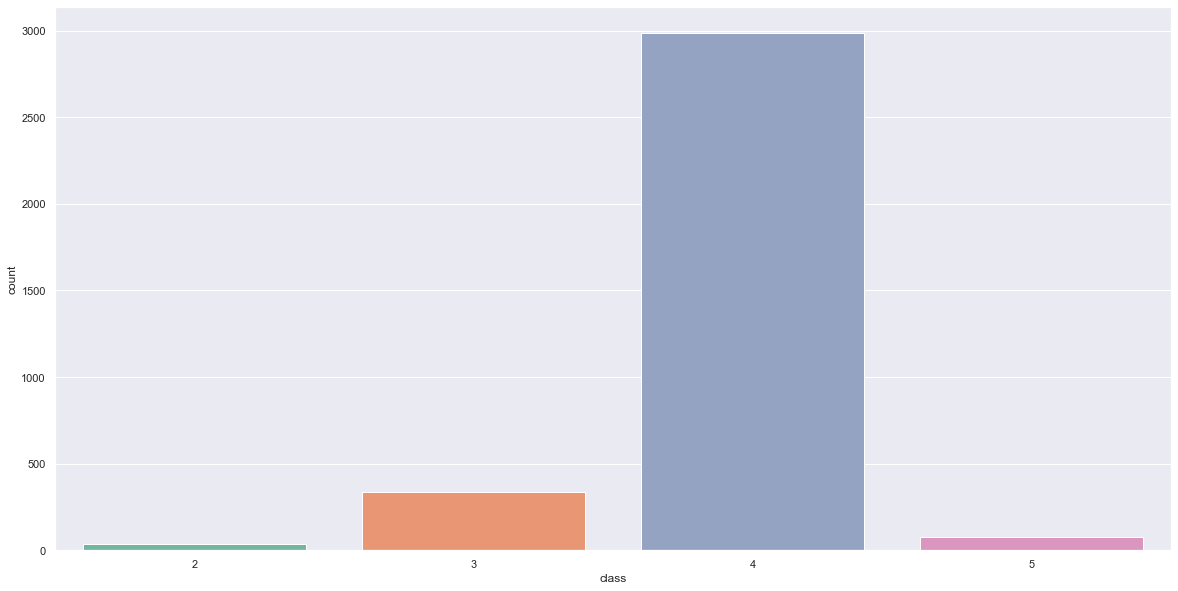

In [16]:
df.loc[df['class'] == 1, 'class'] = 2
df.loc[df['class'] == 3, 'class'] = 2
df.loc[df['class'] == 4, 'class'] = 3
df.loc[df['class'] == 5, 'class'] = 3
df.loc[df['class'] == 6, 'class'] = 4
df.loc[df['class'] == 7, 'class'] = 4
df.loc[df['class'] == 8, 'class'] = 5

sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='class', data=df, palette="Set2")

In [17]:
df['class'].value_counts()

4    2988
3     337
5      77
2      39
Name: class, dtype: int64

In [18]:
feature_columns = [col for col in df.columns if col not in ['class', 'name', 'text', 'type']]
X = df[feature_columns]
y = df['class'] - 2
y.loc[y == 1] = 3
y.loc[y == 0] = 3
y.loc[y == 2] = 3
y.loc[y == 5] = 6

y.loc[y == 3] = 0
y.loc[y == 4] = 1
y.loc[y == 6] = 2

In [24]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state = SEED)

Так как количество элементов в классах не равномерно то объединим классы 2,3,4,5; 7, 8; и уберем часть элементов из 6 класса

In [25]:
train_y.value_counts()

1    2139
2     322
0     291
Name: class, dtype: int64

In [26]:
dummy = train_y.loc[train_y == 1][:315]
train_y.drop(train_y.loc[train_y == 1].index, inplace=True)
train_y = pd.concat([train_y, dummy], ignore_index=True)
train_y.value_counts()

2    322
1    315
0    291
Name: class, dtype: int64

In [27]:
y_idx = train_y.index
train_x = train_x.iloc[y_idx.to_list()]
train_x.reset_index(inplace=True, drop=True)
test_x.reset_index(inplace=True, drop=True)
train_y = train_y.reset_index(drop=True)
test_y = test_y.reset_index(drop=True)

## Попробуем подобрать различные классификаторы

In [11]:
def model_res(est):
    est.fit(train_x, train_y)
    pred_y = est.predict(test_x)
    cm = confusion_matrix(test_y, pred_y)
    acc = accuracy_score(test_y, pred_y)
    print('Accuracy: ', acc, '\n')
    print('Confusion matrix: \n', cm)

In [12]:
def first_round_search(est, param_grid, num_iter=100):
    grid = RandomizedSearchCV(estimator=est,
                          param_distributions=param_grid,
                          n_iter = num_iter,
                          scoring='accuracy',
                          n_jobs=-1,
                          verbose=1,
                          cv=3,
                          random_state=SEED)
    grid_result = grid.fit(train_x, train_y)
    rs_df = pd.DataFrame(grid_result.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
    rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params',
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
    params_labels = [param for param in rs_df.columns if 'param' in param]
    
    cols = ceil(np.sqrt(len(params_labels)))
    lines = ceil(len(params_labels)/cols)
    fig, axs = plt.subplots(ncols=cols, nrows=lines)
    sns.set(style="whitegrid", color_codes=True, font_scale = 2)
    fig.set_size_inches(30,30)
    
    col = 0
    line = 0
    for param in params_labels:
        sns.barplot(x=param, y='mean_test_score', data=rs_df, ax=axs[line, col])
        axs[line, col].set_ylim([rs_df.groupby(param).mean()['mean_test_score'].min()*0.95,
                                 rs_df.groupby(param).mean()['mean_test_score'].max()*1.05])
        axs[line, col].set_title(label = param.replace('param_', ''), size=25, weight='bold')
        
        if col < cols - 1:
            col += 1
        else:
            line += 1
            col = 0
    return (grid_result.best_score_, grid_result.best_params_, grid_result.best_estimator_)

### knn

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [187]:
param_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 50, num = 20)],
              'p': [1, 2],
              'weights': ['uniform', 'distance']}
param_grid

{'n_neighbors': [1,
  3,
  6,
  8,
  11,
  13,
  16,
  19,
  21,
  24,
  26,
  29,
  31,
  34,
  37,
  39,
  42,
  44,
  47,
  50],
 'p': [1, 2],
 'weights': ['uniform', 'distance']}

1 раунд

C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 217 out of 240 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.8s finished


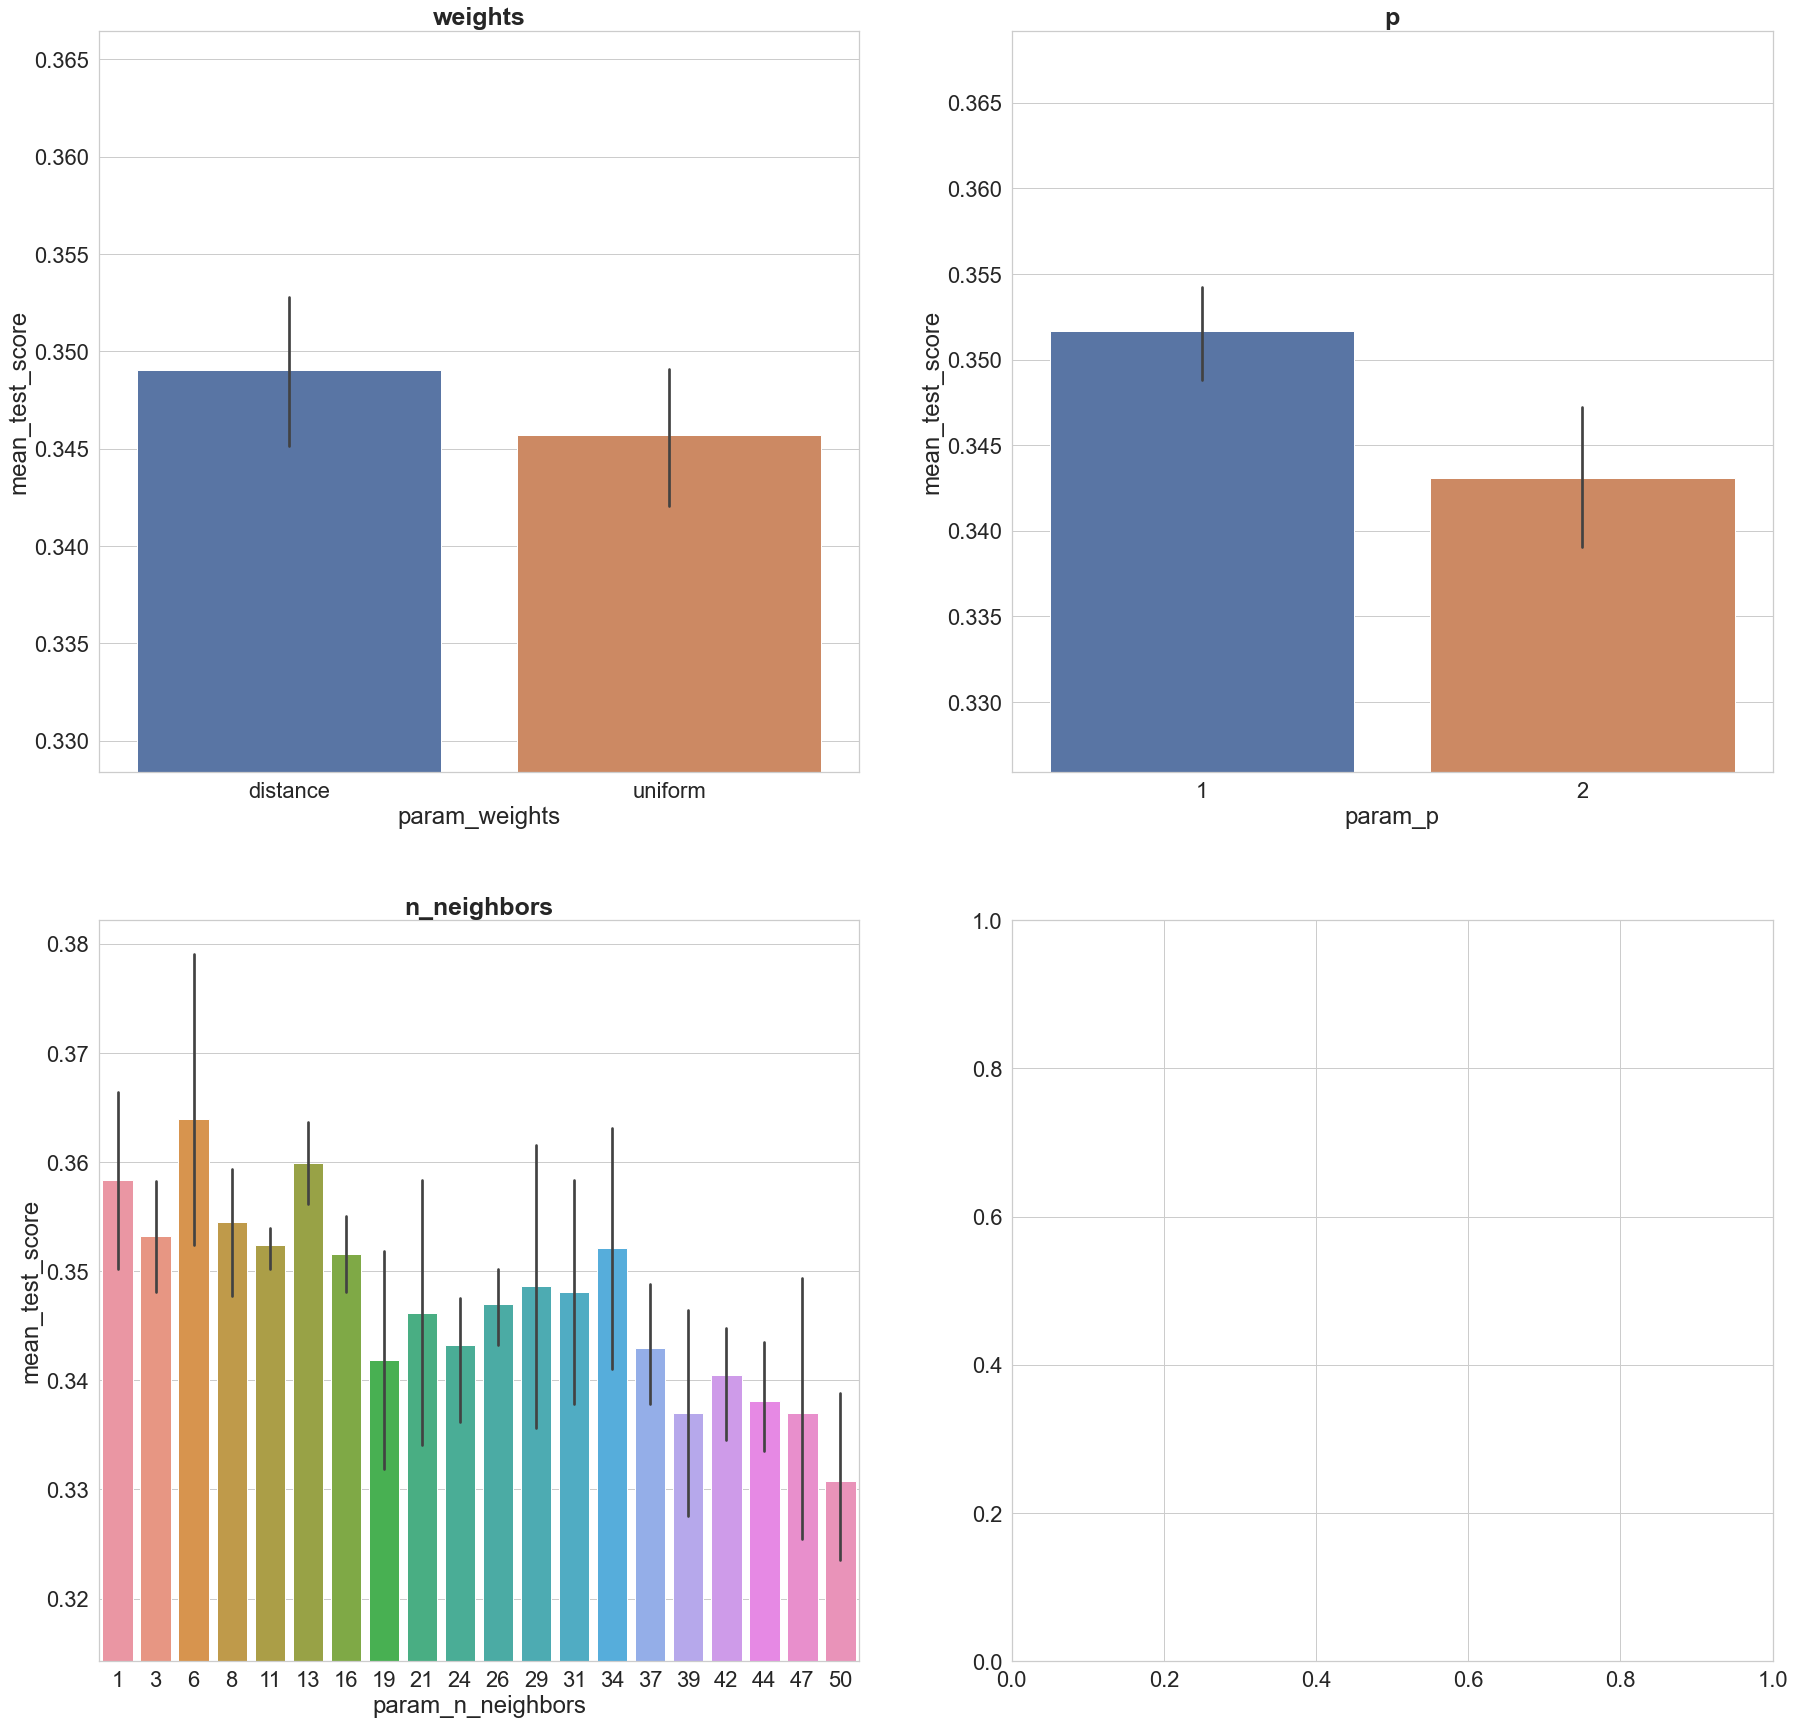

In [193]:
first_round_search(KNeighborsClassifier(metric='minkowski', algorithm='auto'), param_grid, 100)

2 раунд

In [ ]:
param_grid = {'n_neighbors': [4, 5, 6, 7],
              'p': [1,],
              'weights': ['distance',]}
param_grid

In [194]:
grid = GridSearchCV(estimator=KNeighborsClassifier(metric='minkowski', algorithm='auto'), param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=1, cv=3)
grid_result = grid.fit(train_x, train_y)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.8s finished


In [195]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.386853 using {'n_neighbors': 6, 'p': 2, 'weights': 'distance'}


In [196]:
model_res(grid_result.best_estimator_)

Accuracy:  0.34593023255813954 

Confusion matrix: 
 [[ 26  32  26]
 [181 189 171]
 [ 18  22  23]]


### RandomForest

In [102]:
from sklearn.ensemble import RandomForestClassifier

1 раунд

In [201]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
              'max_features': ['auto', 'log2', 'sqrt'],
              'max_depth': [1, 5, 10, 15, 20, 30],
              'min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
              'min_samples_leaf': [int(x) for x in np.linspace(start = 30, stop = 80, num = 10)],
              'bootstrap': [True, False]}
param_grid

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'max_features': ['auto', 'log2', 'sqrt'],
 'max_depth': [1, 5, 10, 15, 20, 30],
 'min_samples_split': [2, 7, 12, 18, 23, 28, 34, 39, 44, 50],
 'min_samples_leaf': [30, 35, 41, 46, 52, 57, 63, 68, 74, 80],
 'bootstrap': [True, False]}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   39.3s finished


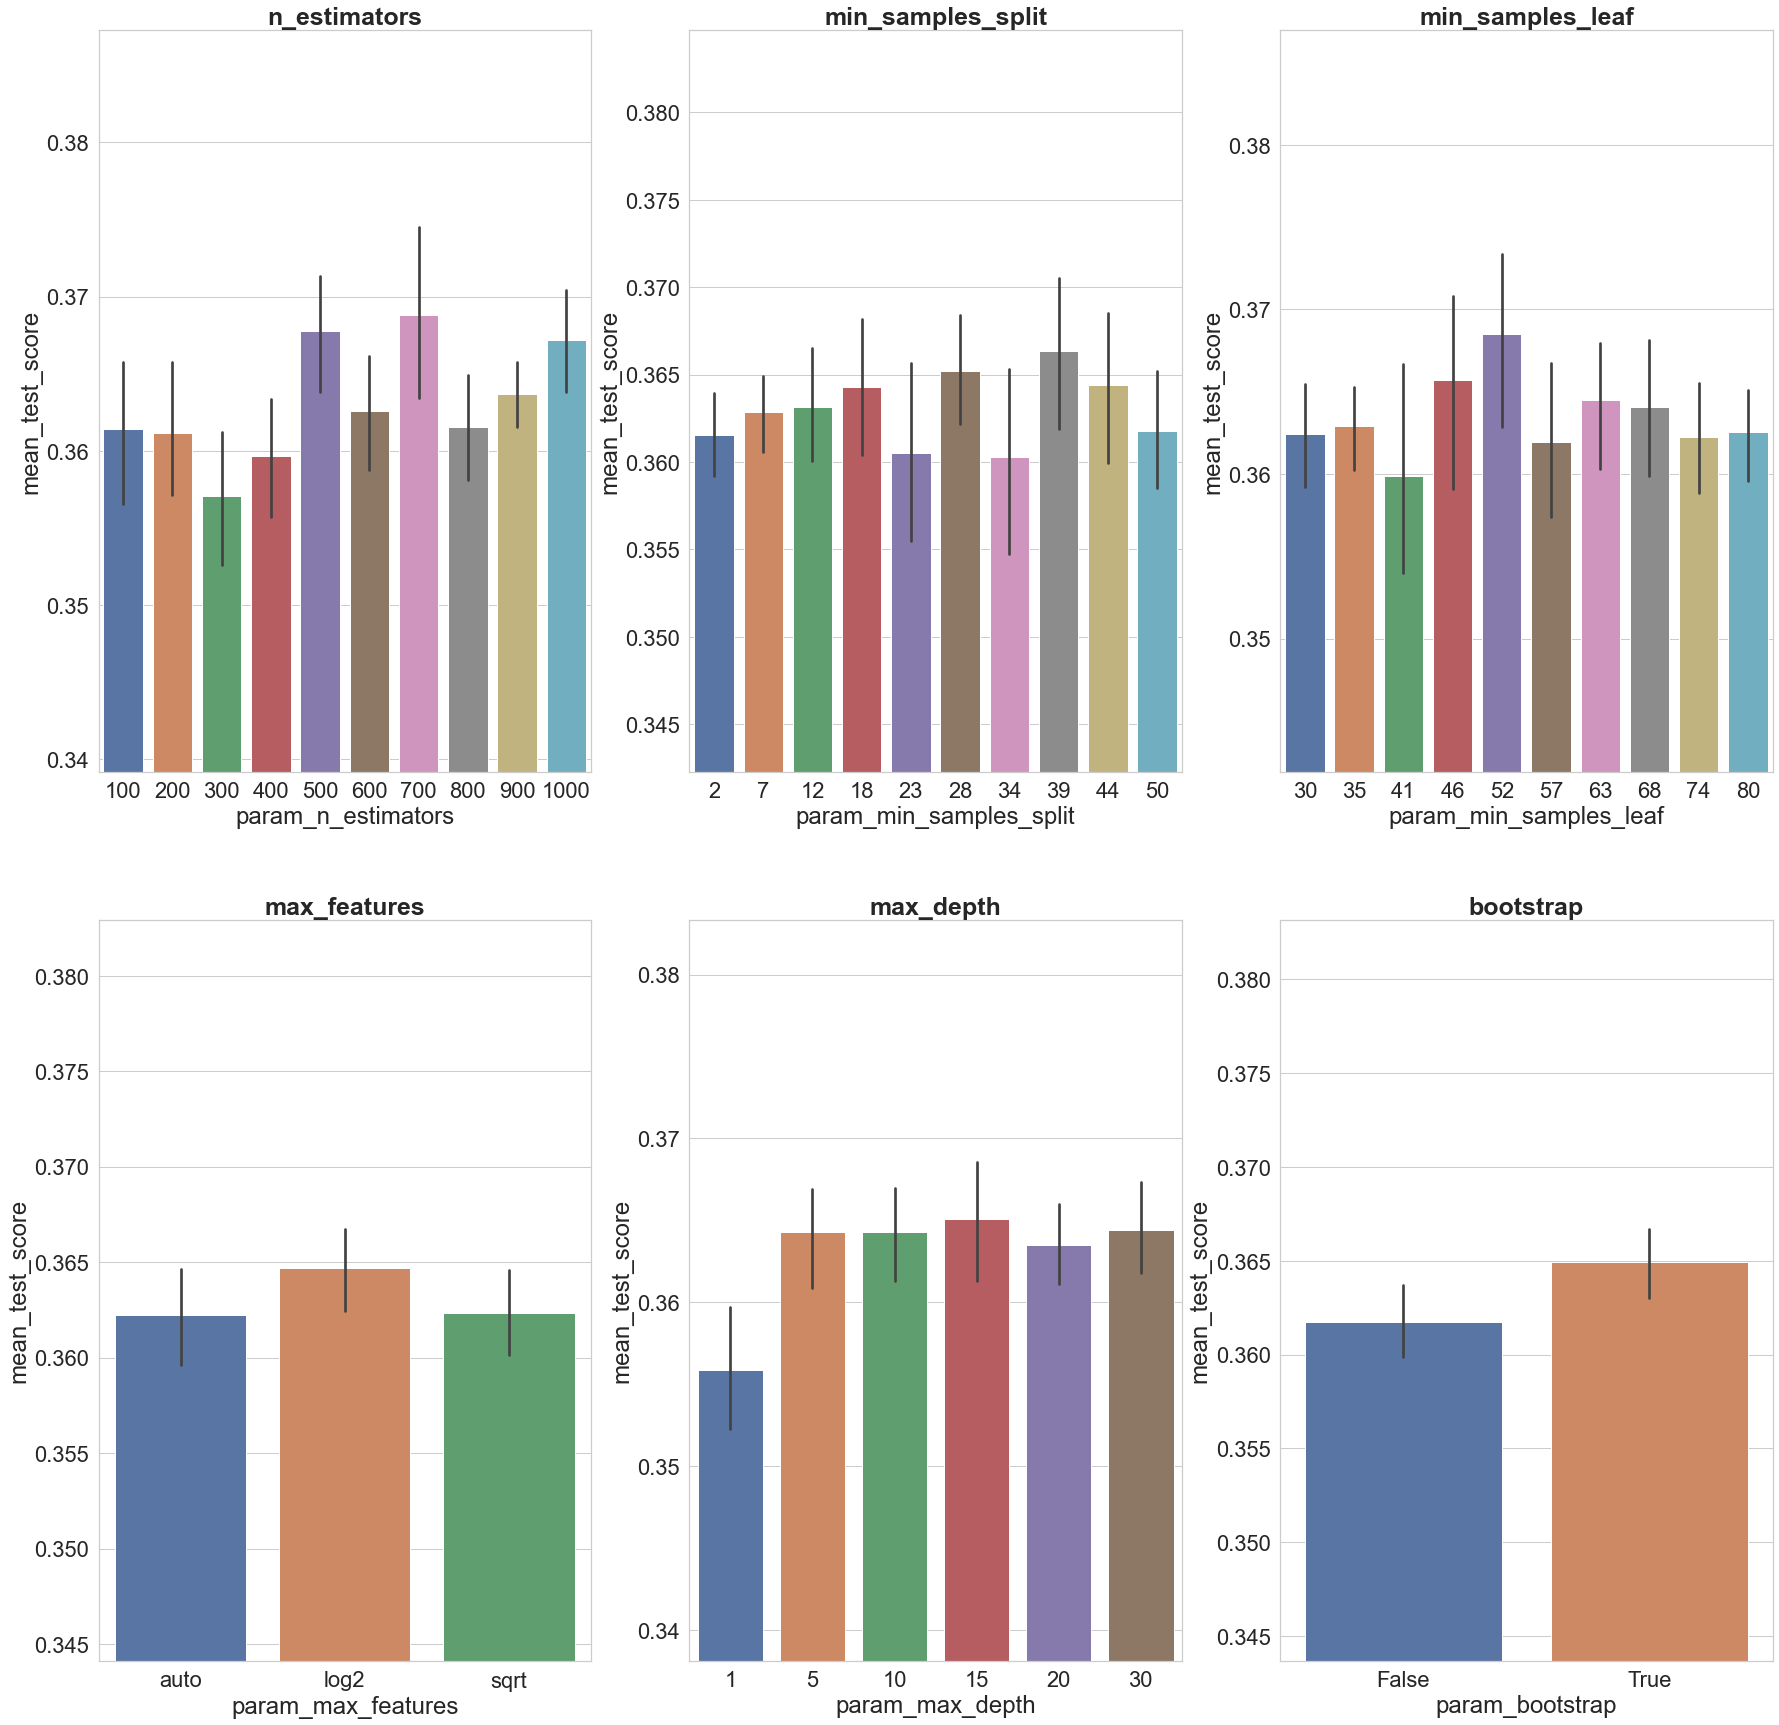

In [202]:
first_round_search(RandomForestClassifier(), param_grid, 100)

2 раунд

In [203]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 680, stop = 720, num = 10)],
              'max_features': ['log2',],
              'max_depth': [14, 15, 16],
              'min_samples_split': [11, 12, 13, 27, 28, 29, 38, 39, 40],
              'min_samples_leaf': [50, 51, 52, 53, 54],
              'bootstrap': [True, ]}
param_grid

{'n_estimators': [680, 684, 688, 693, 697, 702, 706, 711, 715, 720],
 'max_features': ['log2'],
 'max_depth': [14, 15, 16],
 'min_samples_split': [11, 12, 13, 27, 28, 29, 38, 39, 40],
 'min_samples_leaf': [50, 51, 52, 53, 54],
 'bootstrap': [True]}

In [204]:
grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=1, cv=3)
grid_result = grid.fit(train_x, train_y)

Fitting 3 folds for each of 1350 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed: 12.4min finished


In [205]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.387918 using {'bootstrap': True, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 52, 'min_samples_split': 12, 'n_estimators': 680}


In [206]:
model_res(grid_result.best_estimator_)

Accuracy:  0.35901162790697677 

Confusion matrix: 
 [[  5  23  56]
 [ 51 214 276]
 [  5  30  28]]


### XGBoost

In [208]:
import xgboost as xgb

1 раунд

In [213]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
              'learning_rate': [0.01, 0.1, 0.2, 0,3],
              'max_depth': [1, 5, 10, 15],
              'gamma': [0, 0.1, 0.2],
              'min_child_weight': [0, 0.5, 1],
              'subsample': [0.7, 0.8, 0.9, 1],
              'colsample_bytree': [0.6, 0.8, 1],
              'reg_alpha': [0, 1e-2, 1, 1e1],
              'reg_lambda': [0, 1e-2, 1, 1e1]}
param_grid

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'learning_rate': [0.01, 0.1, 0.2, 0, 3],
 'max_depth': [1, 5, 10, 15],
 'gamma': [0, 0.1, 0.2],
 'min_child_weight': [0, 0.5, 1],
 'subsample': [0.7, 0.8, 0.9, 1],
 'colsample_bytree': [0.6, 0.8, 1],
 'reg_alpha': [0, 0.01, 1, 10.0],
 'reg_lambda': [0, 0.01, 1, 10.0]}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.6min finished
C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:15:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


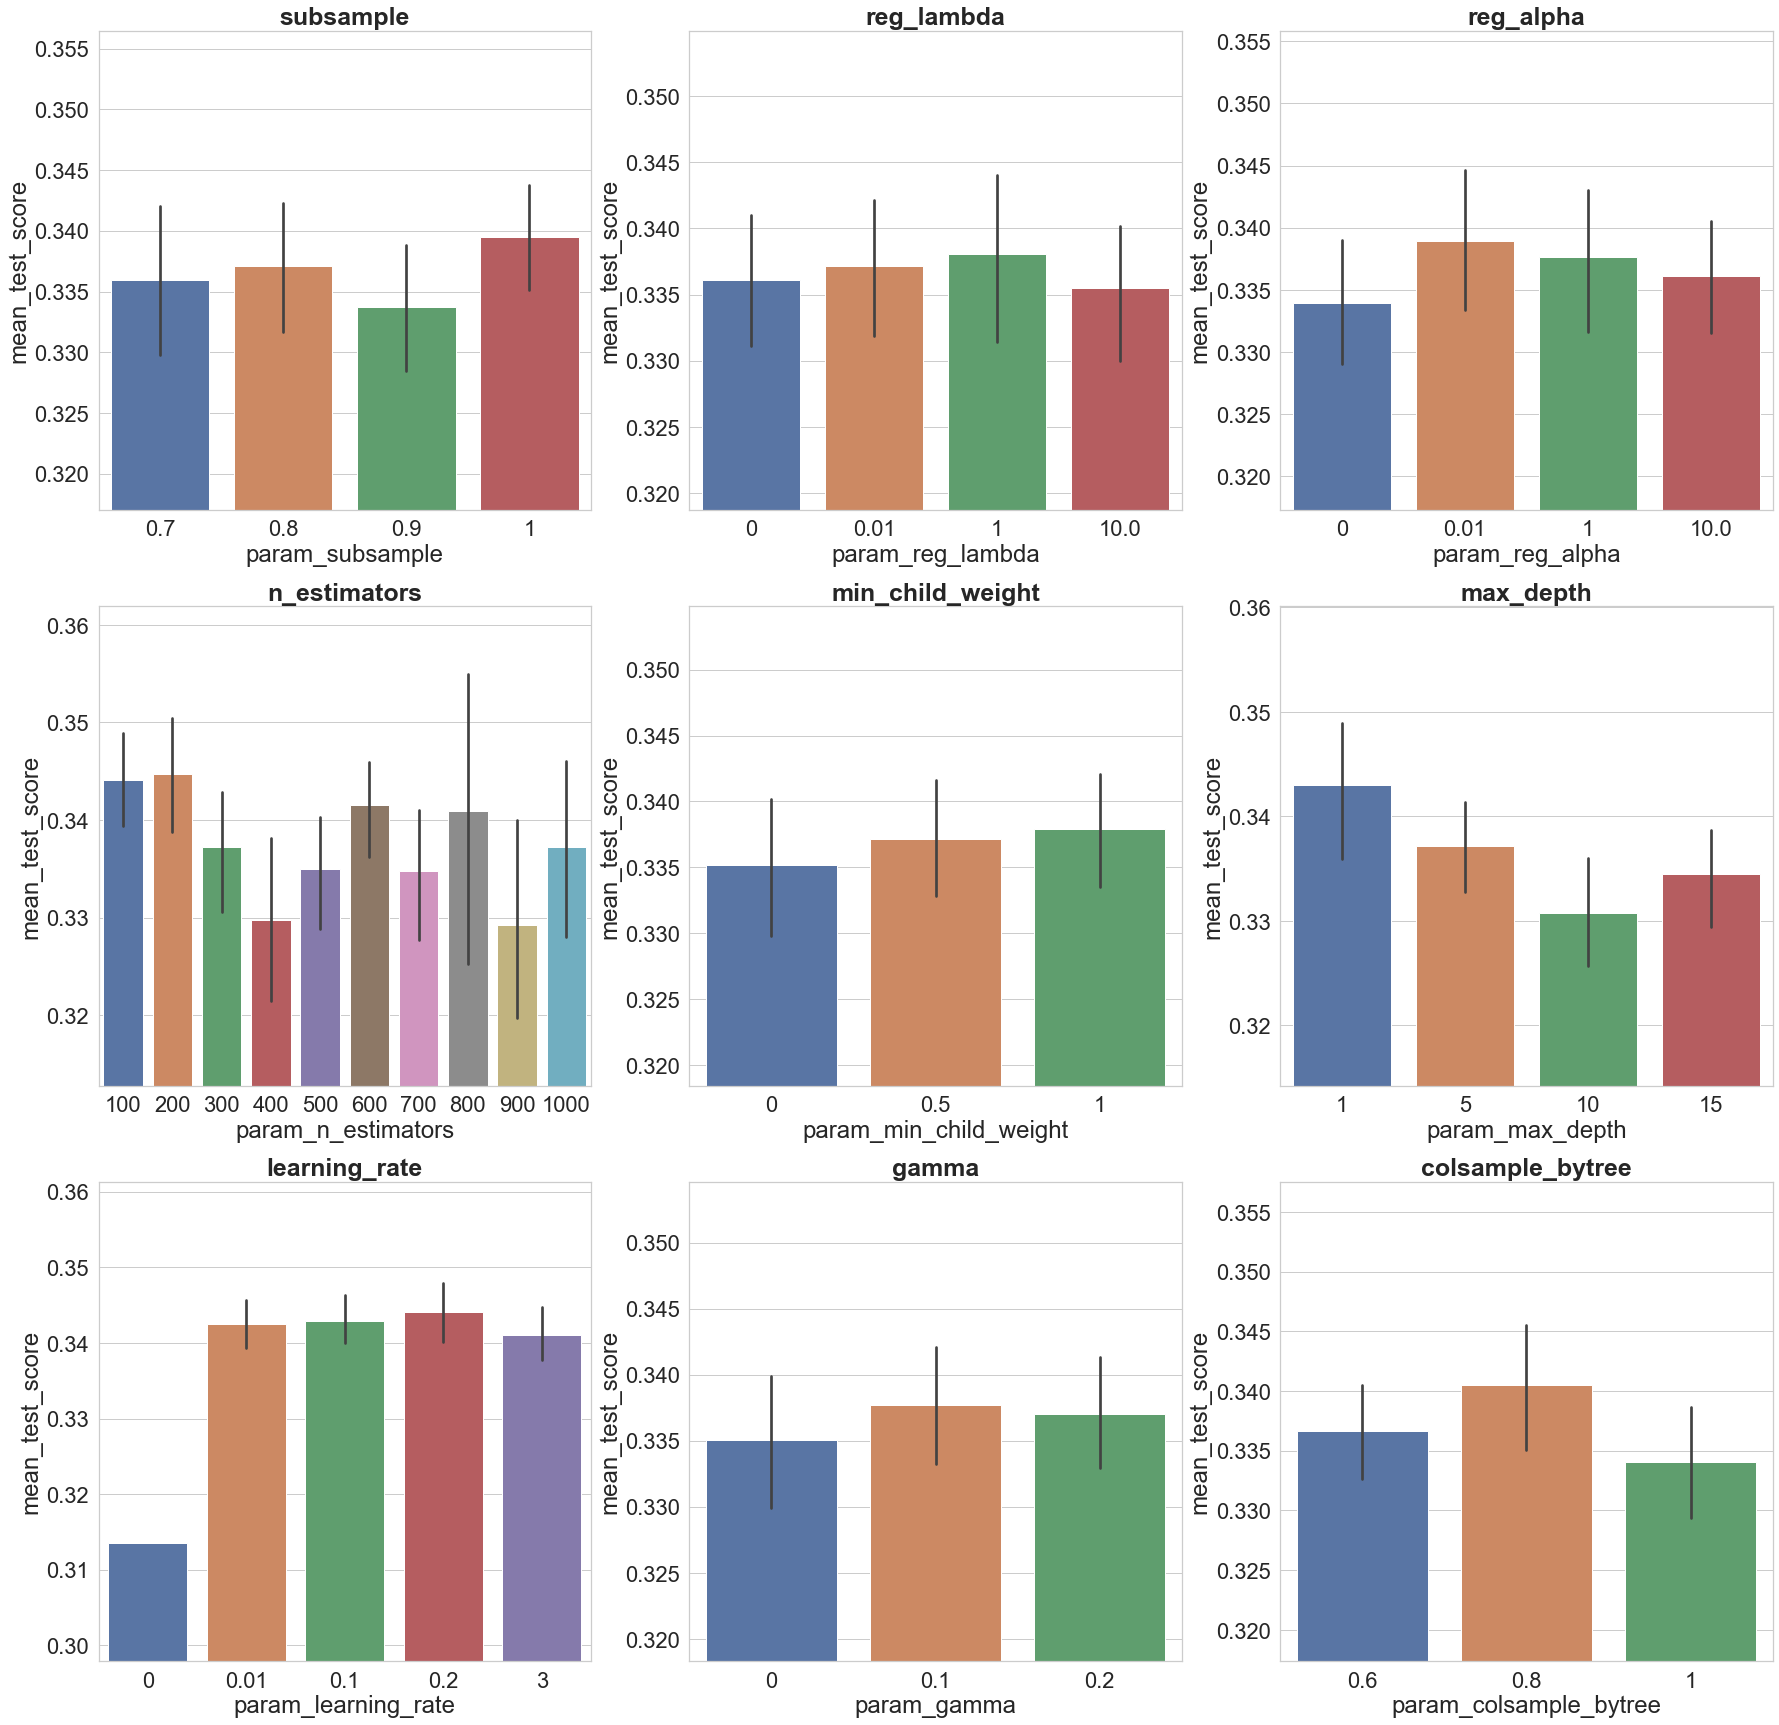

In [214]:
first_round_search(xgb.XGBRFClassifier(), param_grid, 100)

2 раунд

In [215]:
param_grid = {'n_estimators': [100, 200],
              'learning_rate': [0.2,],
              'max_depth': [1, 2, 3],
              'gamma': [0.09, 0.1, 0.15],
              'min_child_weight': [1,],
              'subsample': [1,],
              'colsample_bytree': [0.7, 0.8, 0.9],
              'reg_alpha': [0.01,],
              'reg_lambda': [1,]}
param_grid

{'n_estimators': [100, 200],
 'learning_rate': [0.2],
 'max_depth': [1, 2, 3],
 'gamma': [0.09, 0.1, 0.15],
 'min_child_weight': [1],
 'subsample': [1],
 'colsample_bytree': [0.7, 0.8, 0.9],
 'reg_alpha': [0.01],
 'reg_lambda': [1]}

In [216]:
grid = GridSearchCV(estimator=xgb.XGBRFClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=1, cv=3)
grid_result = grid.fit(train_x, train_y)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   14.0s finished
C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [217]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.355604 using {'colsample_bytree': 0.8, 'gamma': 0.09, 'learning_rate': 0.2, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 1}


In [218]:
model_res(grid_result.best_estimator_)

[18:30:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.3953488372093023 

Confusion matrix: 
 [[ 10  33  41]
 [ 45 233 263]
 [  4  30  29]]


### SVM

In [219]:
from sklearn.svm import SVC

1 раунд

In [229]:
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'],
              'class_weight': [None, 'balanced'],
              'decision_function_shape': ['ovr', 'ovo']}
param_grid

{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
 'C': [0.1, 1, 10, 100, 1000],
 'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'],
 'class_weight': [None, 'balanced'],
 'decision_function_shape': ['ovr', 'ovo']}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.2s finished


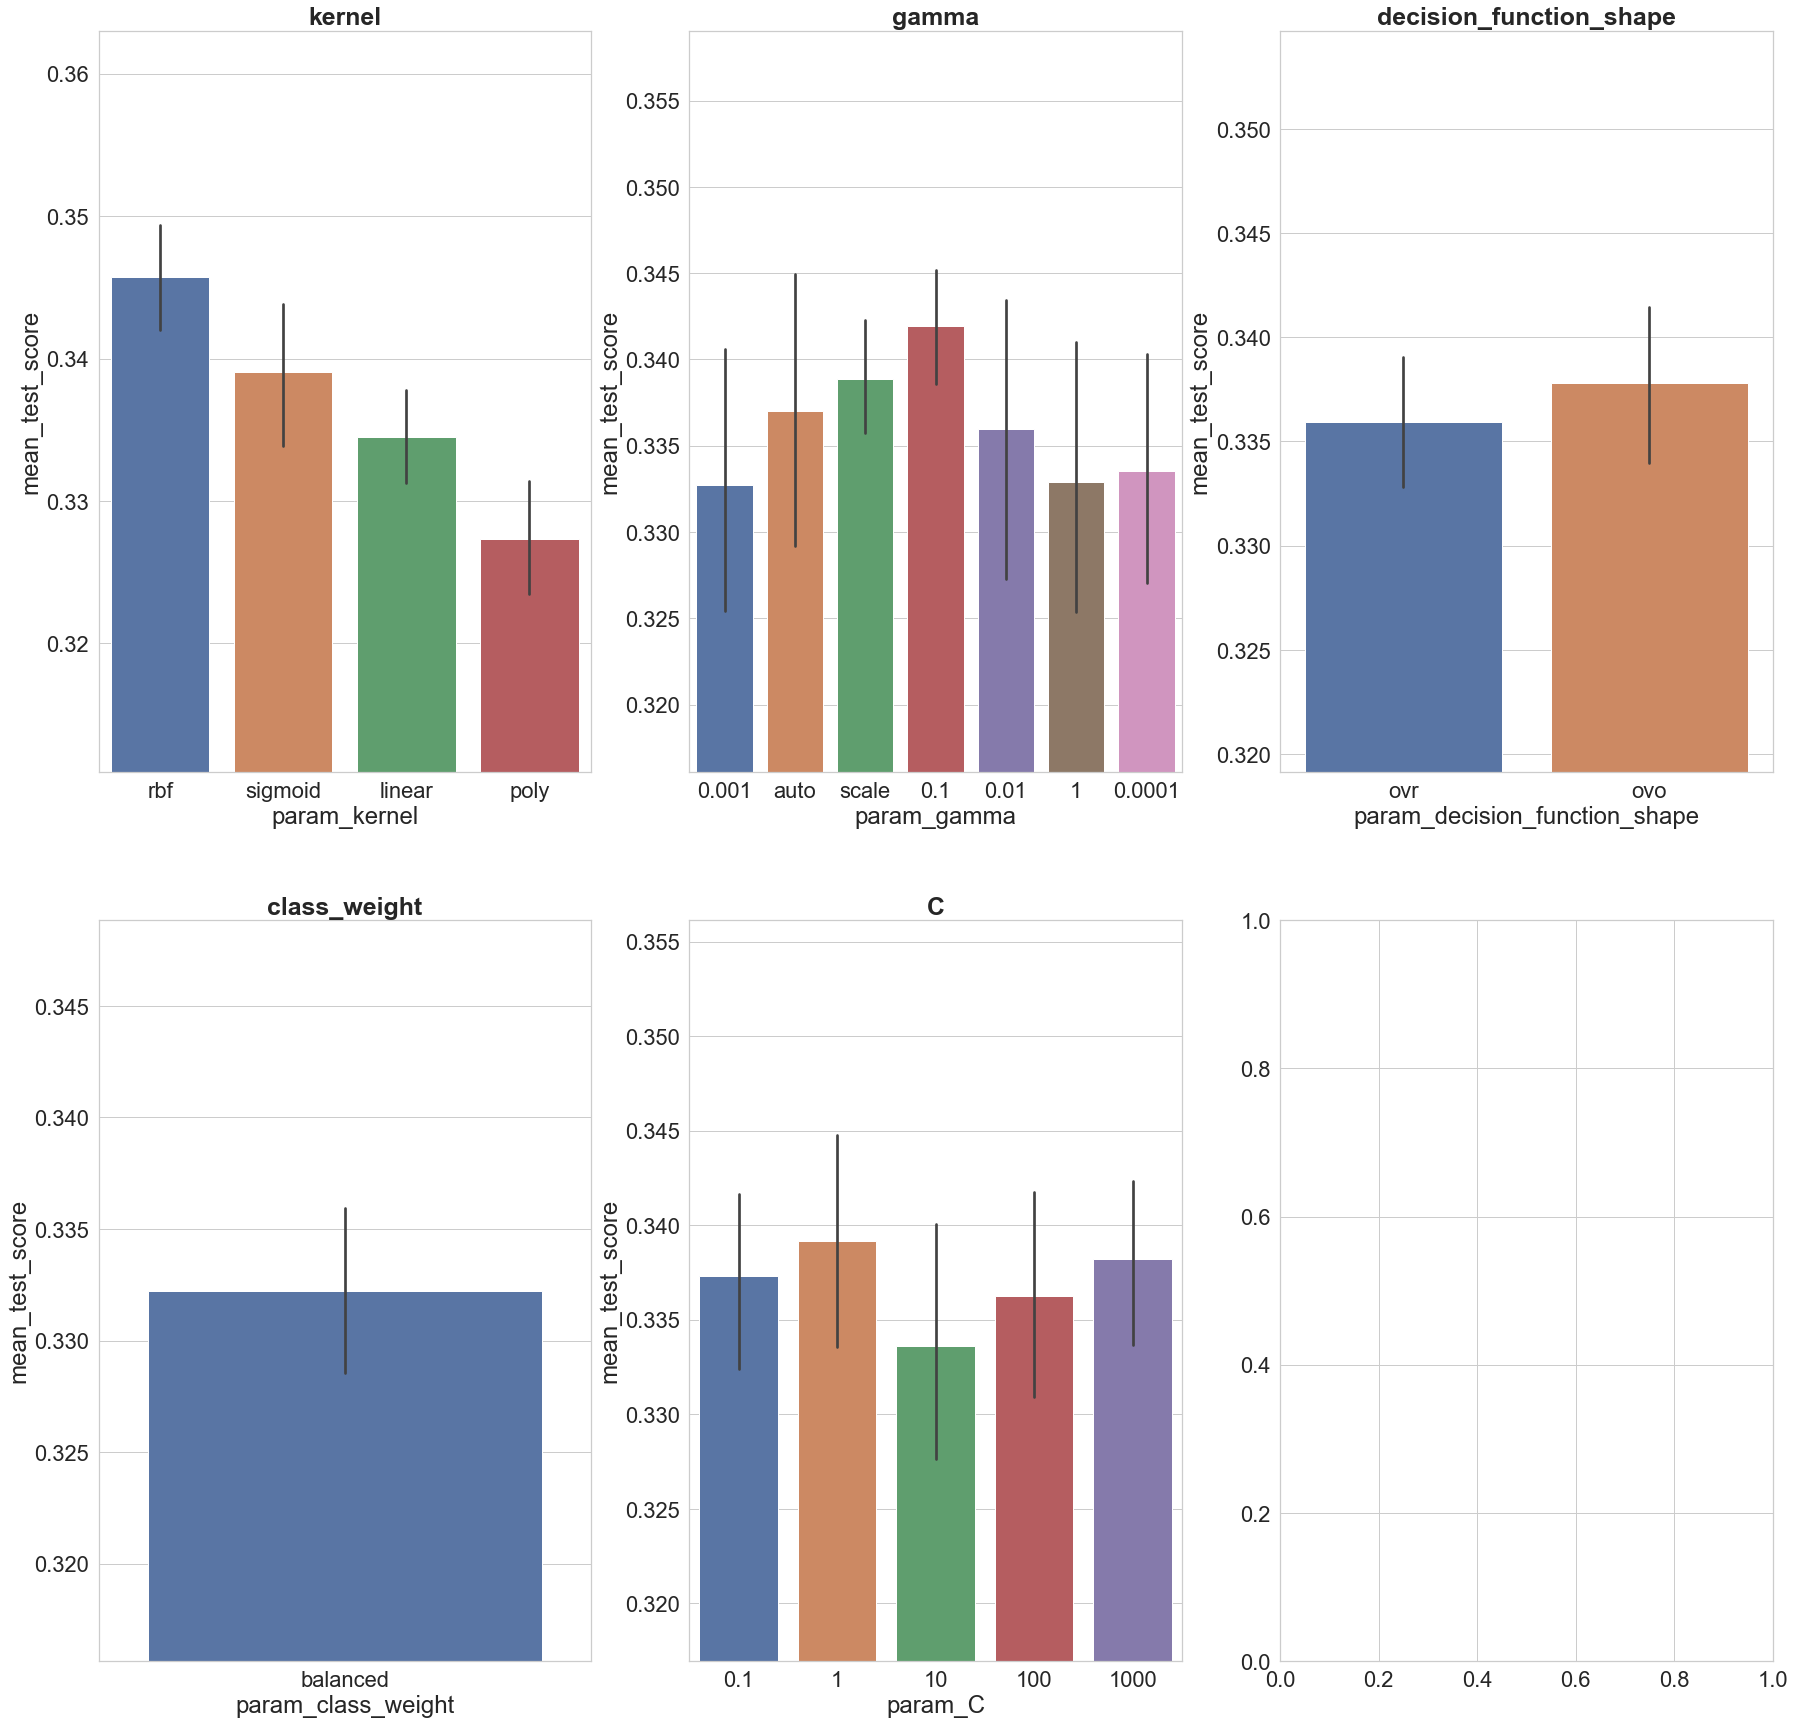

In [235]:
first_round_search(SVC(max_iter=10000), param_grid, 100)

2 раунд

In [236]:
param_grid = {'kernel': ['rbf',],
              'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'],
              'class_weight': [None, 'balanced'],
              'decision_function_shape': ['ovr', 'ovo']}
param_grid

{'kernel': ['rbf'],
 'C': [0.1, 1, 10, 100, 1000],
 'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'],
 'class_weight': [None, 'balanced'],
 'decision_function_shape': ['ovr', 'ovo']}

In [237]:
grid = GridSearchCV(estimator=SVC(max_iter=10000), param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=1, cv=3)
grid_result = grid.fit(train_x, train_y)

Fitting 3 folds for each of 140 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 397 out of 420 | elapsed:    3.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    3.5s finished


In [238]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.378248 using {'C': 10, 'class_weight': None, 'decision_function_shape': 'ovr', 'gamma': 0.01, 'kernel': 'rbf'}


In [239]:
model_res(grid_result.best_estimator_)

Accuracy:  0.2877906976744186 

Confusion matrix: 
 [[ 17  28  39]
 [ 64 139 338]
 [  7  14  42]]


## Попробуем обучить модели на сгенерированных данных (половины текстов)

In [18]:
df_gen = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\generated_data.csv', index_col='idx')
df_gen.drop(['text',],  inplace=True, axis=1)
df_gen.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_pres_sing,num_pres_plur,num_past_part,num_past_simple,num_linkings,num_4grams,num_func_ngrams,million_mistake,sum_punct,cls
idx,,,,,,,,,,,,,,,,,,,,,
0,3.69,7,2,2,2,0,13,189,4.23,14.54,...,7,0,2,4,6,3,1,0,0,4
1,3.93,7,2,1,3,1,15,244,4.80,16.27,...,14,0,3,0,13,2,0,0,0,4


In [19]:
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9100 entries, 0 to 9099
Data columns (total 67 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   av_depth            9100 non-null   float64
 1   max_depth           9100 non-null   int64  
 2   min_depth           9100 non-null   int64  
 3   num_acl             9100 non-null   int64  
 4   num_rel_cl          9100 non-null   int64  
 5   num_advcl           9100 non-null   int64  
 6   num_sent            9100 non-null   int64  
 7   num_tok             9100 non-null   int64  
 8   av_tok_before_root  9100 non-null   float64
 9   av_len_sent         9100 non-null   float64
 10  num_cl              9100 non-null   int64  
 11  num_tu              9100 non-null   int64  
 12  num_compl_tu        9100 non-null   int64  
 13  num_coord           9100 non-null   int64  
 14  num_poss            9100 non-null   int64  
 15  num_prep            9100 non-null   int64  
 16  num_ad

In [20]:
df_gen['cls'].value_counts()

5    2441
4    2386
3    2257
2    2016
Name: cls, dtype: int64

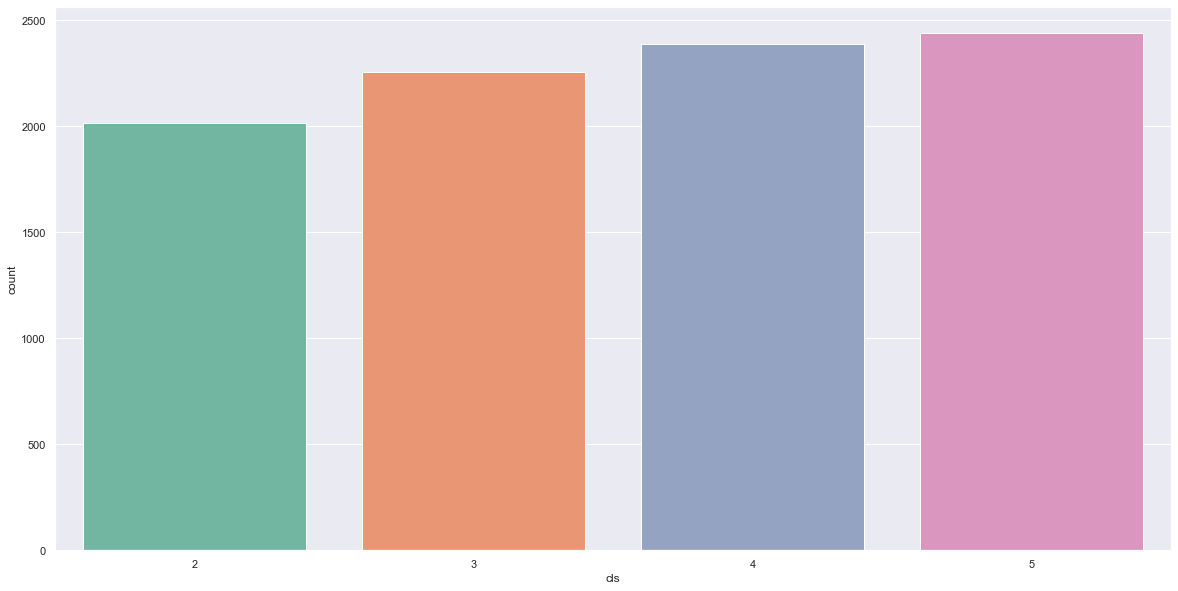

In [21]:
sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='cls', data=df_gen, palette="Set2")

Т.к. сгенерированны данные только для тренировочной выборки, то тестовую выборку получим из начальных данных

In [22]:
df = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\classification_dataset.csv')
df.drop(['num_misspelled_tokens', 'num_shell_noun', 'name', 'type', 'punct_mistakes_pp', 'punct_mistakes_because', 'punct_mistakes_but', 'punct_mistakes_compare', 'side_mistake', 'text'],  inplace=True, axis=1)
df['class'] = round(df['class'] / 10).astype(int)
df.loc[df['class'] == 1, 'class'] = 2
df.loc[df['class'] == 3, 'class'] = 2
df.loc[df['class'] == 4, 'class'] = 3
df.loc[df['class'] == 5, 'class'] = 3
df.loc[df['class'] == 6, 'class'] = 4
df.loc[df['class'] == 7, 'class'] = 4
df.loc[df['class'] == 8, 'class'] = 5

df = df.rename(columns = {'class': 'cls'})
feature_columns = [col for col in df.columns if col not in ['cls',]]
X = df[feature_columns]
y = df['cls']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state = SEED)

In [23]:
feature_columns = [col for col in df_gen.columns if col not in ['cls',]]
train_x = df_gen[feature_columns]
train_y = df_gen['cls']

### KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
param_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 50, num = 20)],
              'p': [1, 2],
              'weights': ['uniform', 'distance']}
param_grid

{'n_neighbors': [1,
  3,
  6,
  8,
  11,
  13,
  16,
  19,
  21,
  24,
  26,
  29,
  31,
  34,
  37,
  39,
  42,
  44,
  47,
  50],
 'p': [1, 2],
 'weights': ['uniform', 'distance']}

1 раунд

C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   22.3s finished


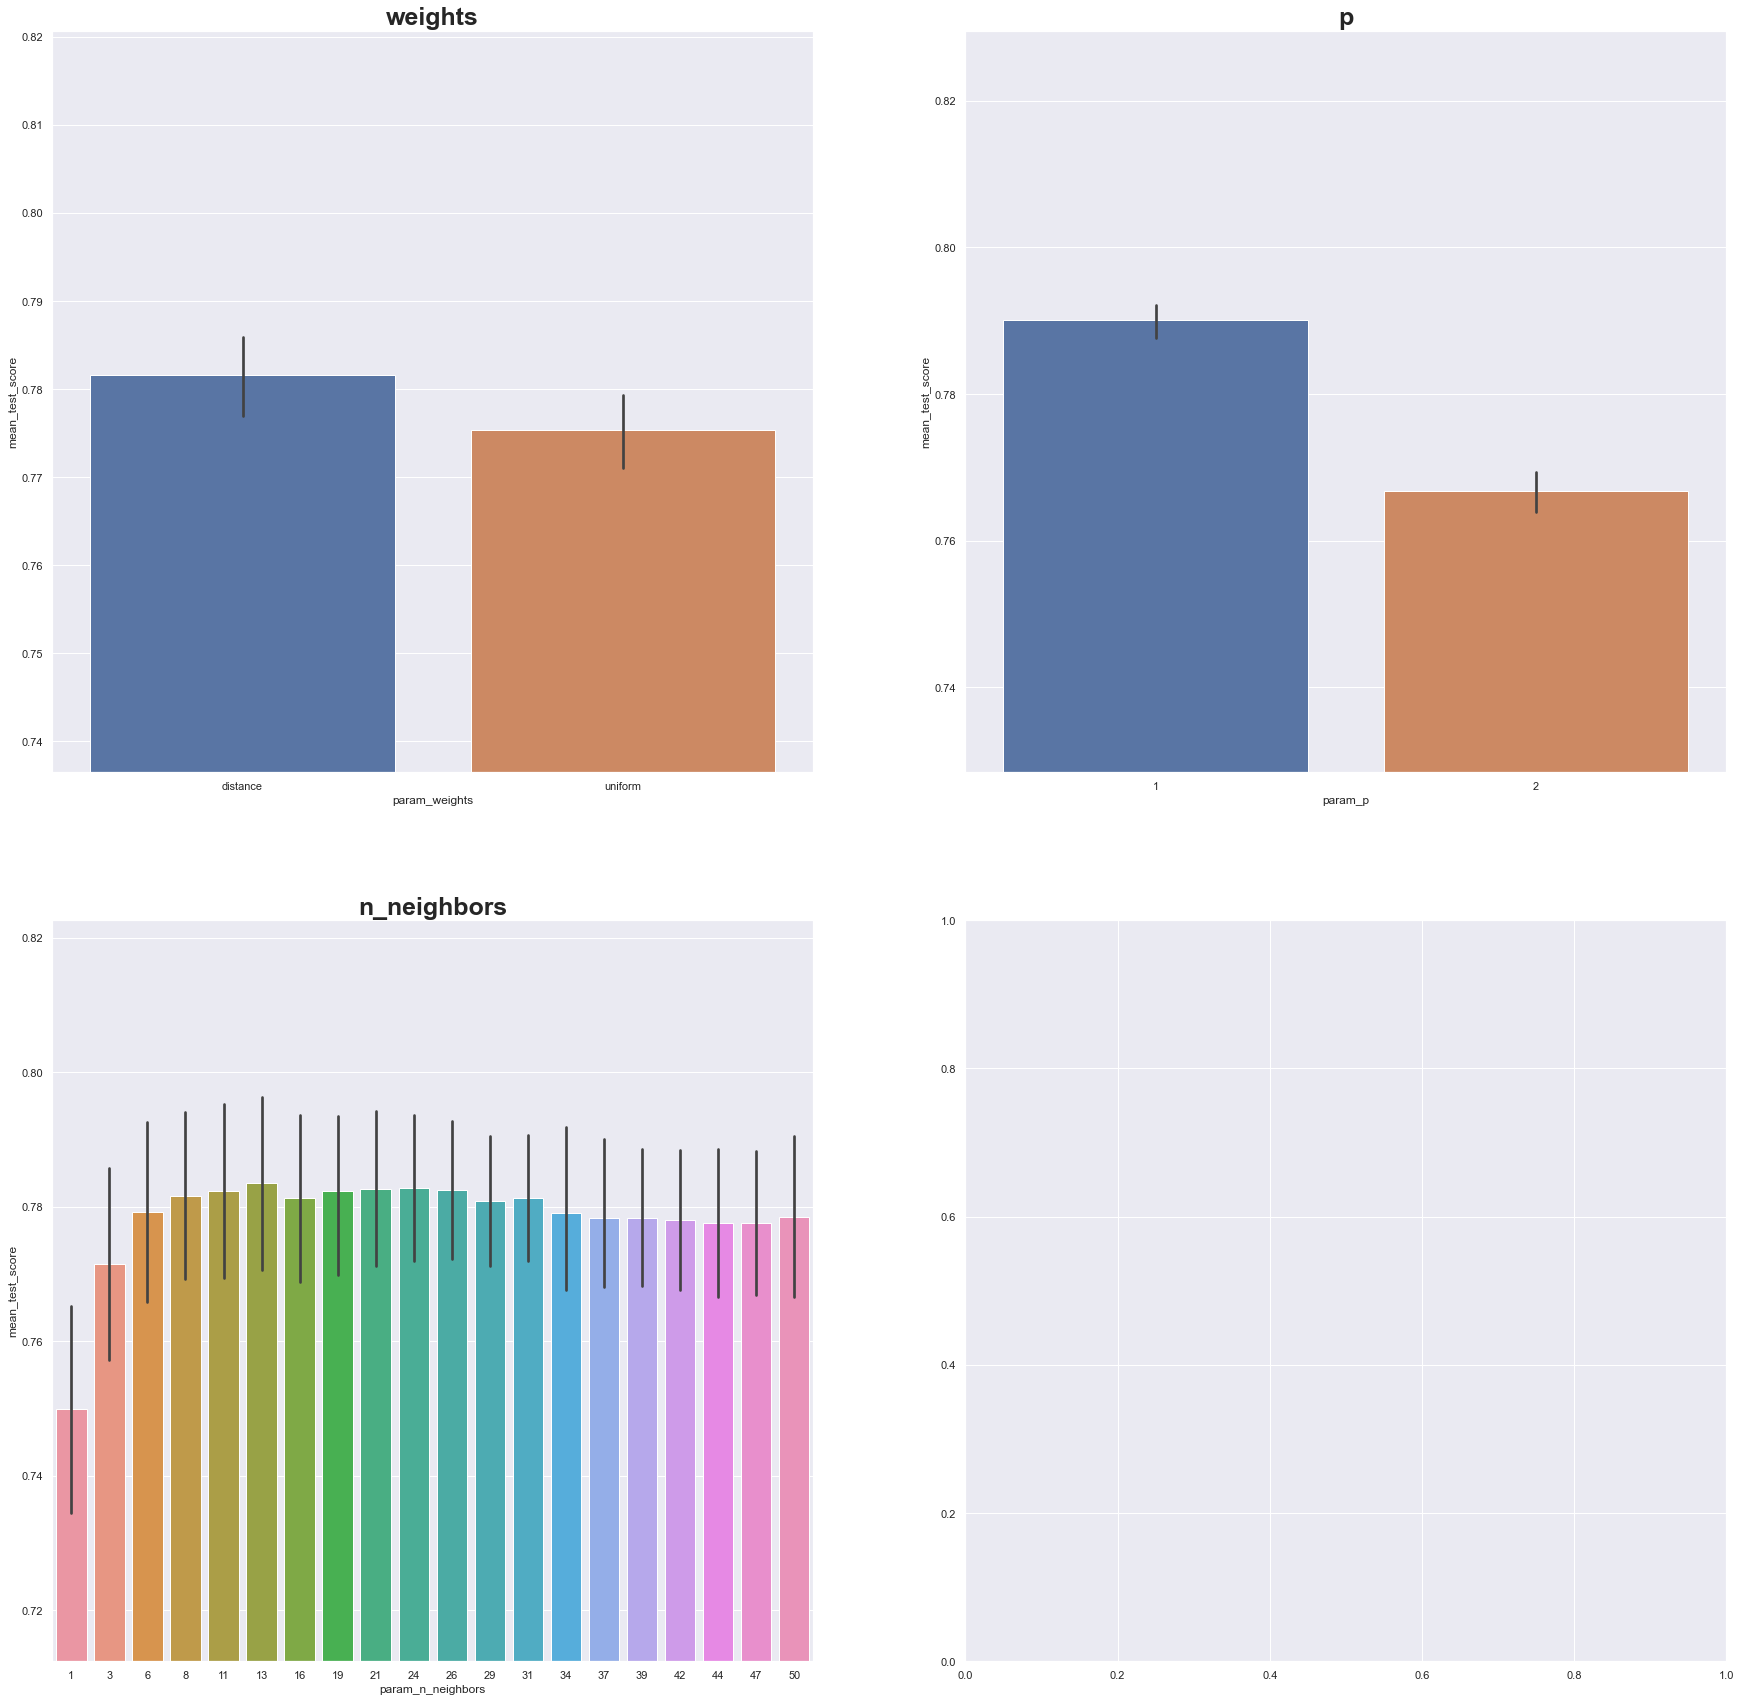

In [26]:
first_round_search(KNeighborsClassifier(metric='minkowski', algorithm='auto'), param_grid, 100)

2 раунд

In [27]:
param_grid = {'n_neighbors': [10, 11, 12, 13, 14, 15],
              'p': [1,],
              'weights': ['distance',]}
param_grid

{'n_neighbors': [10, 11, 12, 13, 14, 15], 'p': [1], 'weights': ['distance']}

In [28]:
grid = GridSearchCV(estimator=KNeighborsClassifier(metric='minkowski', algorithm='auto'), param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=1, cv=3)
grid_result = grid.fit(train_x, train_y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:    4.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    4.3s finished


In [29]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.801106 using {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


In [30]:
model_res(grid_result.best_estimator_)

Accuracy:  0.8766328011611031 

Confusion matrix: 
 [[  2   0   5   0]
 [  5   9  50   0]
 [  0   8 593   1]
 [  0   0  16   0]]


### RandomForest

In [32]:
from sklearn.ensemble import RandomForestClassifier

1 раунд

In [35]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
              'max_features': ['auto', 'log2', 'sqrt'],
              'max_depth': [1, 5, 10, 15, 20, 30],
              'min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
              'min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 80, num = 15)],
              'bootstrap': [True, False]}
param_grid

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'max_features': ['auto', 'log2', 'sqrt'],
 'max_depth': [1, 5, 10, 15, 20, 30],
 'min_samples_split': [2, 7, 12, 18, 23, 28, 34, 39, 44, 50],
 'min_samples_leaf': [2,
  7,
  13,
  18,
  24,
  29,
  35,
  41,
  46,
  52,
  57,
  63,
  68,
  74,
  80],
 'bootstrap': [True, False]}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.0min finished


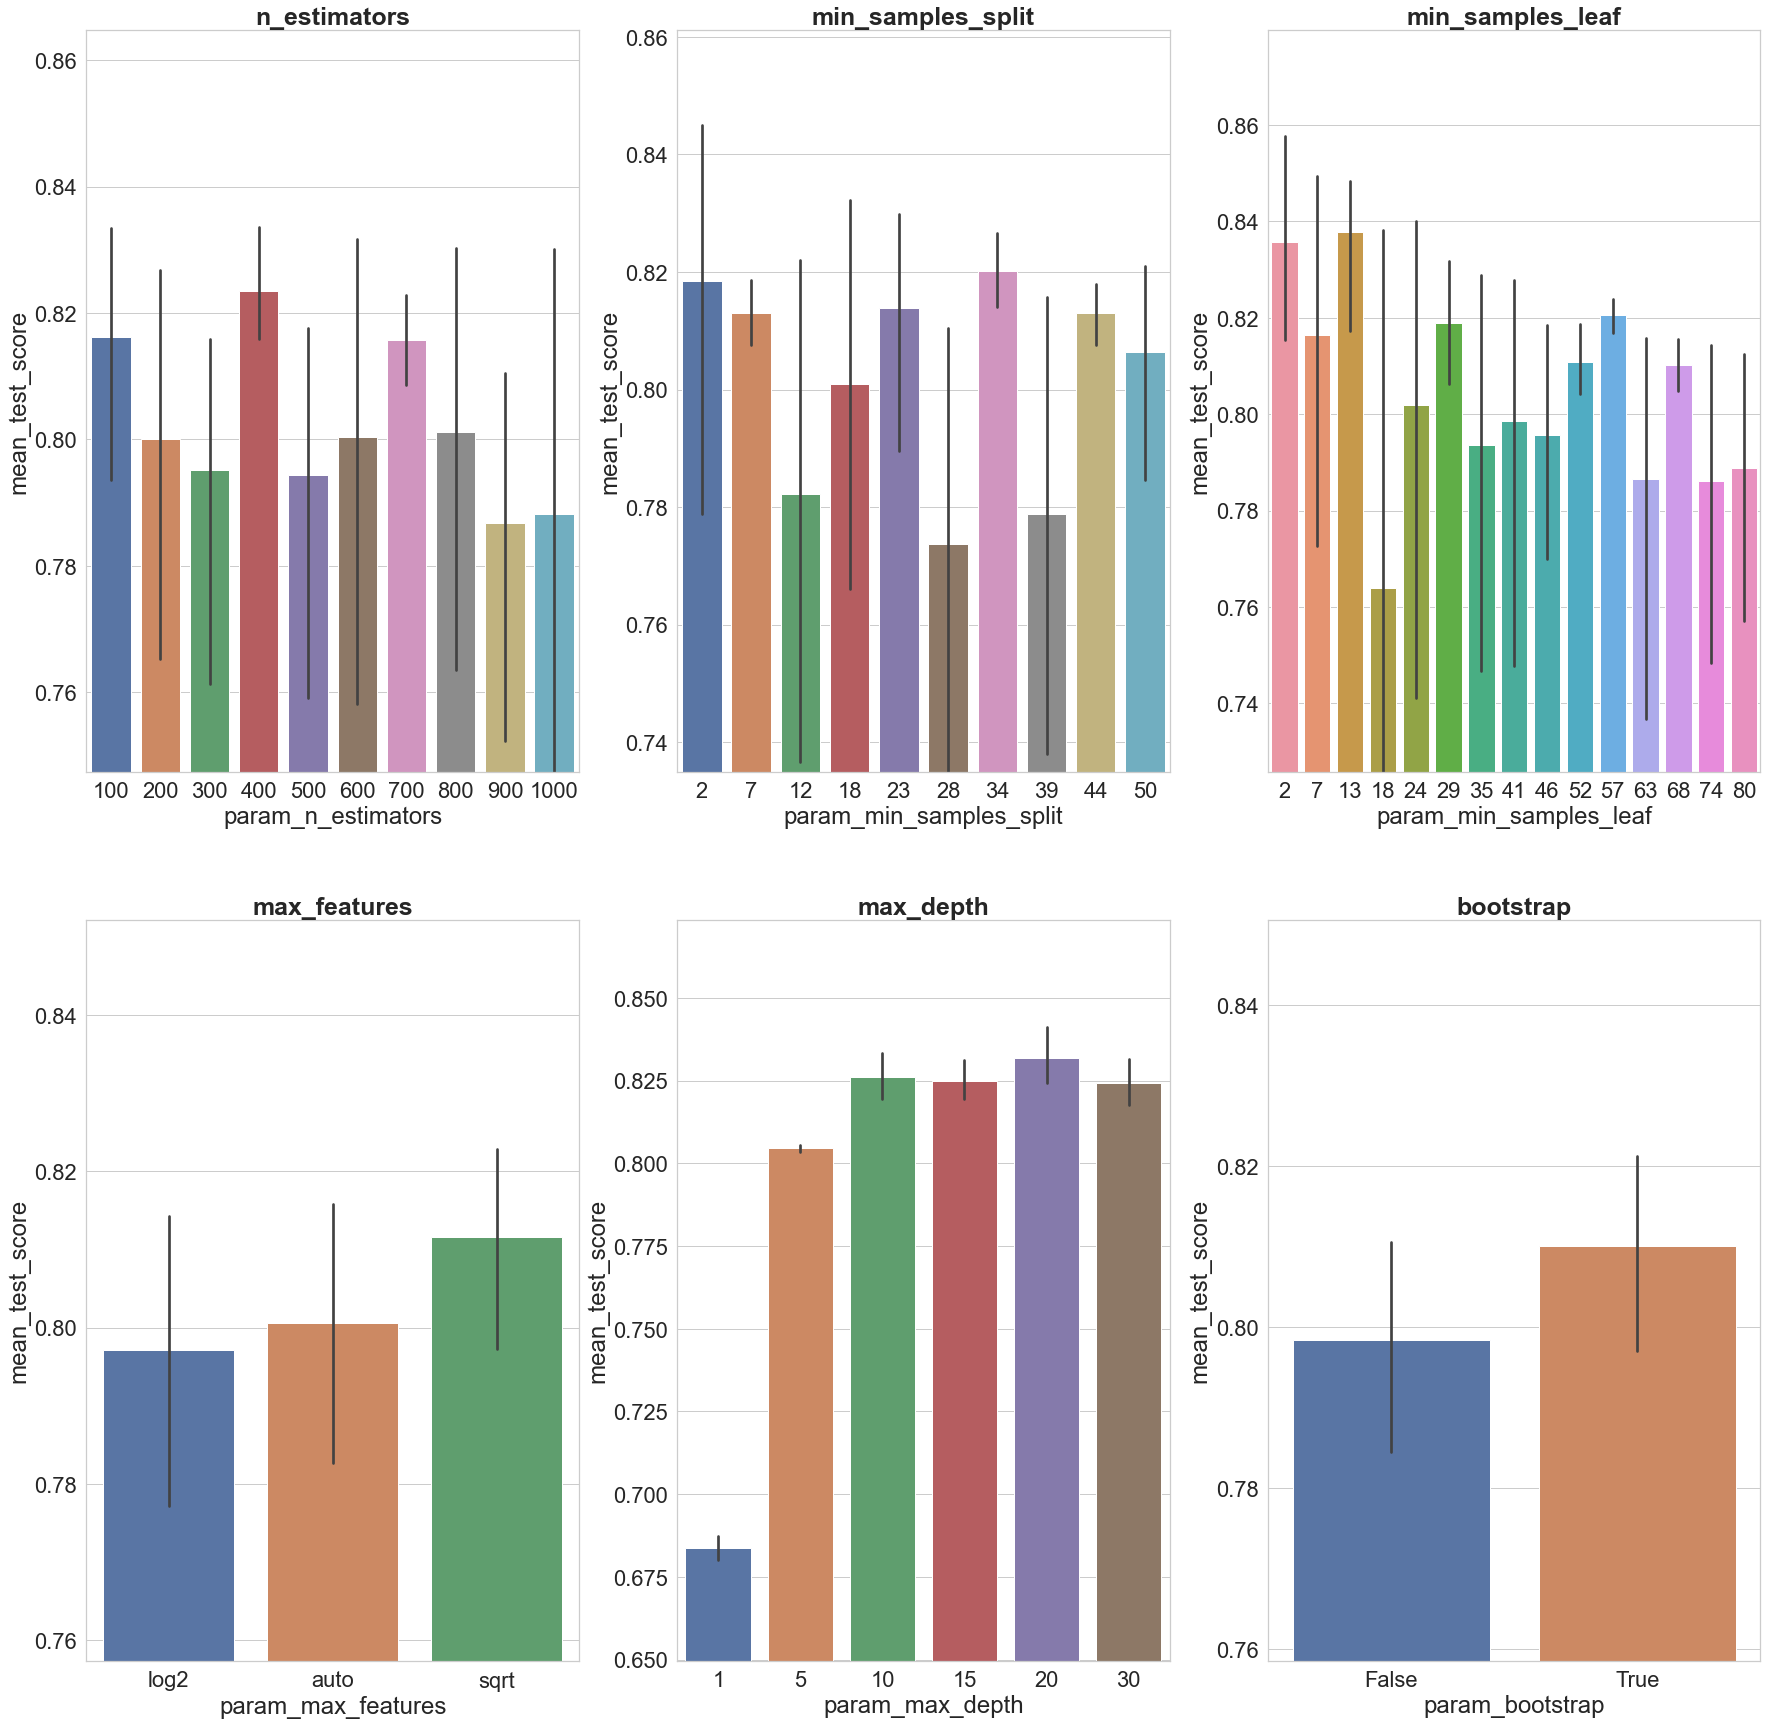

In [36]:
first_round_search(RandomForestClassifier(), param_grid, 100)

2 раунд

In [39]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 380, stop = 420, num = 10)],
              'max_features': ['sqrt',],
              'max_depth': [18, 19, 20, 21, 22],
              'min_samples_split': [29, 31, 33, 34, 35, 37],
              'min_samples_leaf': [1, 2, 3, 11, 13, 15],
              'bootstrap': [True, ]}
param_grid

{'n_estimators': [380, 384, 388, 393, 397, 402, 406, 411, 415, 420],
 'max_features': ['sqrt'],
 'max_depth': [18, 19, 20, 21, 22],
 'min_samples_split': [29, 31, 33, 34, 35, 37],
 'min_samples_leaf': [1, 2, 3, 11, 13, 15],
 'bootstrap': [True]}

In [40]:
grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=1, cv=3)
grid_result = grid.fit(train_x, train_y)

Fitting 3 folds for each of 1800 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 36.1min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 46.1min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 57.0min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed: 61.5min finished


In [41]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.861988 using {'bootstrap': True, 'max_depth': 21, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 29, 'n_estimators': 397}


In [42]:
model_res(grid_result.best_estimator_)

Accuracy:  0.8824383164005806 

Confusion matrix: 
 [[  2   1   4   0]
 [  4  13  47   0]
 [  0   7 593   2]
 [  0   0  16   0]]


### XGBoost

In [43]:
import xgboost as xgb

1 раунд

In [44]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
              'learning_rate': [0.01, 0.1, 0.2, 0,3],
              'max_depth': [1, 5, 10, 15],
              'gamma': [0, 0.1, 0.2],
              'min_child_weight': [0, 0.5, 1],
              'subsample': [0.7, 0.8, 0.9, 1],
              'colsample_bytree': [0.6, 0.8, 1],
              'reg_alpha': [0, 1e-2, 1, 1e1],
              'reg_lambda': [0, 1e-2, 1, 1e1]}
param_grid

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'learning_rate': [0.01, 0.1, 0.2, 0, 3],
 'max_depth': [1, 5, 10, 15],
 'gamma': [0, 0.1, 0.2],
 'min_child_weight': [0, 0.5, 1],
 'subsample': [0.7, 0.8, 0.9, 1],
 'colsample_bytree': [0.6, 0.8, 1],
 'reg_alpha': [0, 0.01, 1, 10.0],
 'reg_lambda': [0, 0.01, 1, 10.0]}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 29.2min finished
C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:45:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


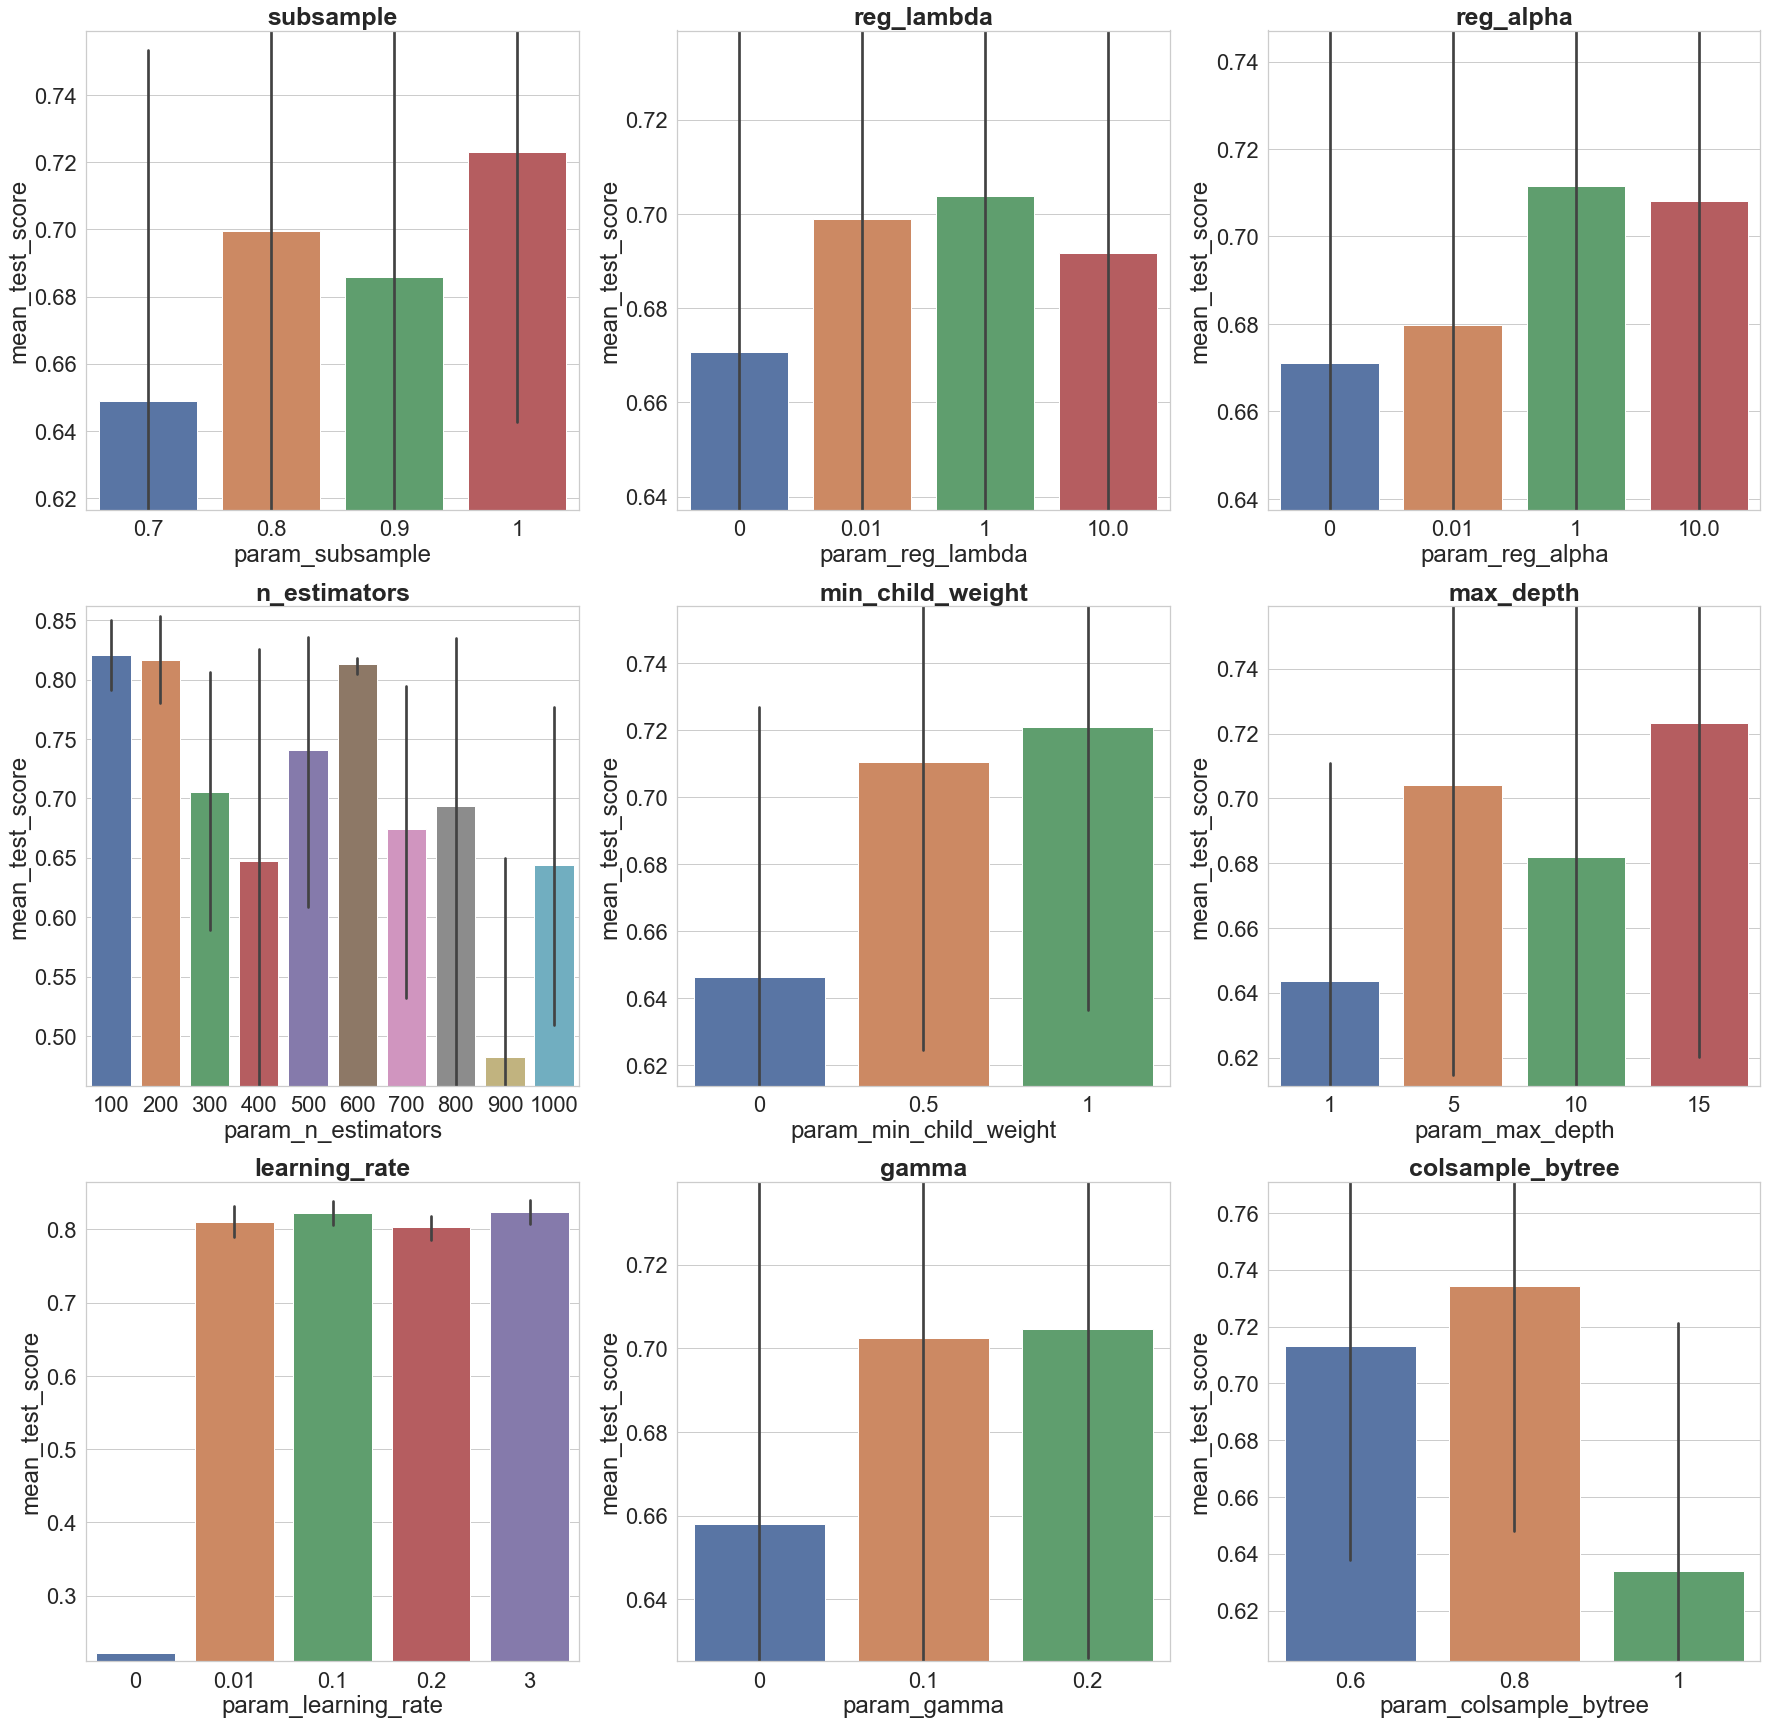

In [45]:
first_round_search(xgb.XGBRFClassifier(), param_grid, 100)

2 раунд

In [53]:
param_grid = {'n_estimators': [100, 580, 600, 620],
              'learning_rate': [0.1, 3],
              'max_depth': [13, 15, 17],
              'gamma': [0.18, 0.2, 0.24],
              'min_child_weight': [0.8, 1, 1.2],
              'subsample': [1, 1.1, 1.2],
              'colsample_bytree': [0.7, 0.8, 0.9],
              'reg_alpha': [1, 2, 3],
              'reg_lambda': [1, 2, 3]}
param_grid

{'n_estimators': [100, 580, 600, 620],
 'learning_rate': [0.1, 3],
 'max_depth': [13, 15, 17],
 'gamma': [0.18, 0.2, 0.24],
 'min_child_weight': [0.8, 1, 1.2],
 'subsample': [1, 1.1, 1.2],
 'colsample_bytree': [0.7, 0.8, 0.9],
 'reg_alpha': [1, 2, 3],
 'reg_lambda': [1, 2, 3]}

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 41.5min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 64.0min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 89.0min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 120.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 144.7min finished
C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  wa

[09:14:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


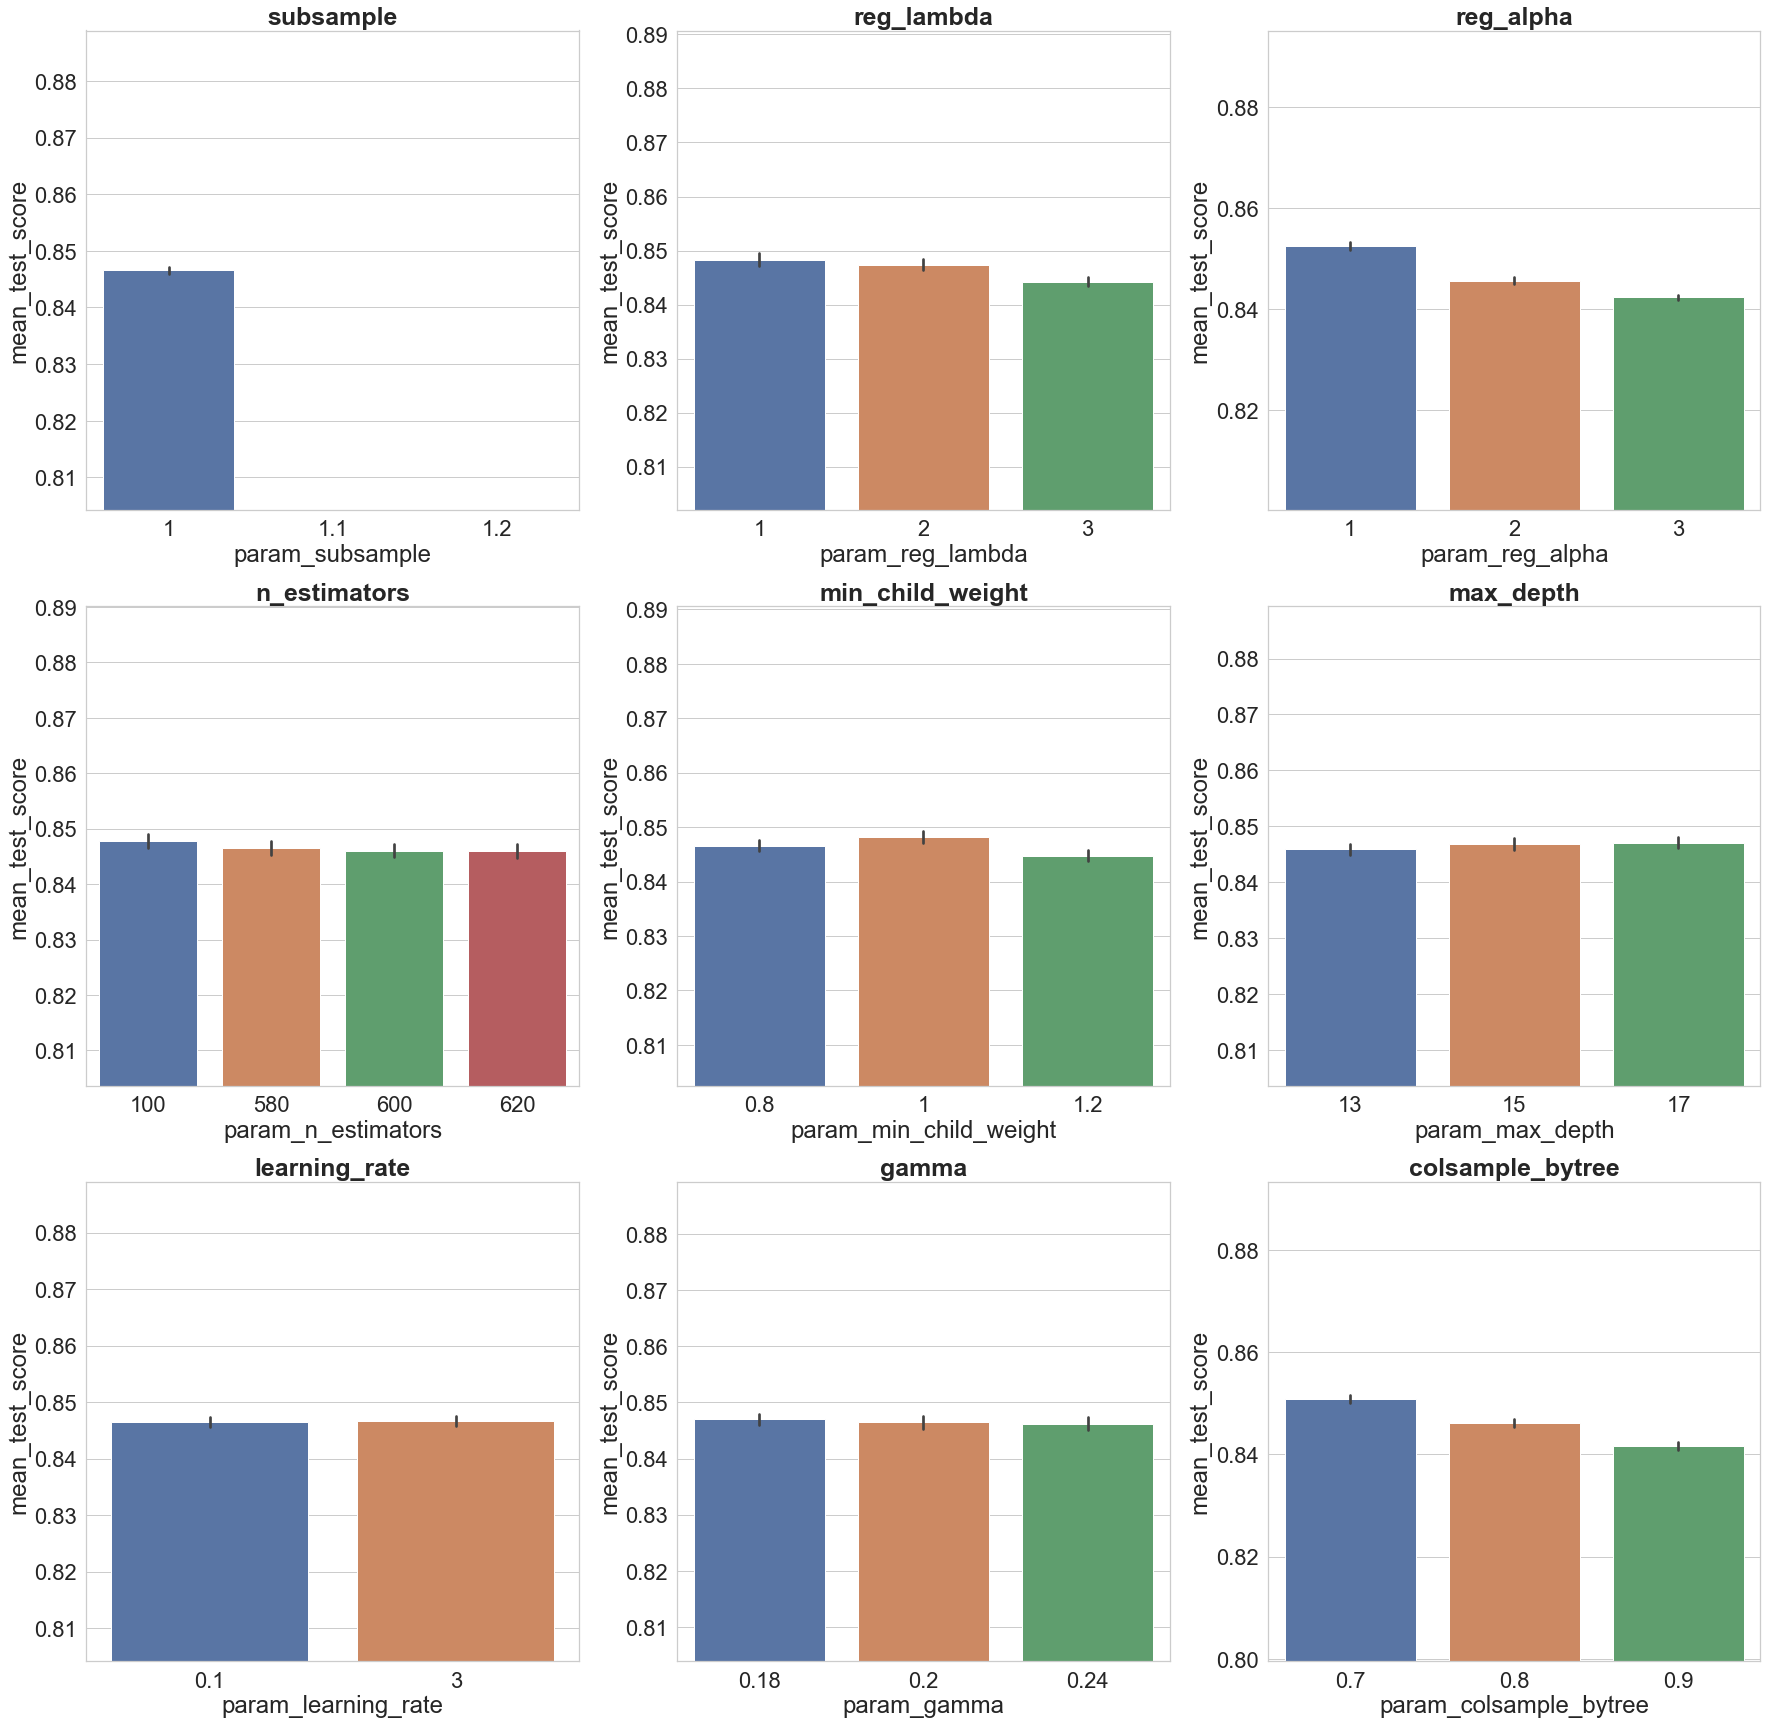

In [54]:
#grid = GridSearchCV(estimator=xgb.XGBRFClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=1, cv=3)
#grid_result = grid.fit(train_x, train_y)
grid_result = first_round_search(xgb.XGBRFClassifier(), param_grid, 1000)

In [56]:
grid_result

(0.8607804808499605,
 {'subsample': 1,
  'reg_lambda': 1,
  'reg_alpha': 1,
  'n_estimators': 100,
  'min_child_weight': 1,
  'max_depth': 17,
  'learning_rate': 3,
  'gamma': 0.2,
  'colsample_bytree': 0.7},
 XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
                 importance_type='gain', interaction_constraints='',
                 learning_rate=3, max_delta_step=0, max_depth=17,
                 min_child_weight=1, missing=nan, monotone_constraints='()',
                 n_estimators=100, n_jobs=12, num_parallel_tree=100,
                 objective='multi:softprob', random_state=0, reg_alpha=1,
                 reg_lambda=1, scale_pos_weight=None, subsample=1,
                 tree_method='exact', validate_parameters=1, verbosity=None))

In [57]:
print("Best: %f using %s" % (grid_result[0], grid_result[1]))

Best: 0.860780 using {'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 17, 'learning_rate': 3, 'gamma': 0.2, 'colsample_bytree': 0.7}


In [59]:
model_res(grid_result[2])

C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:24:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.8795355587808418 

Confusion matrix: 
 [[  2   1   4   0]
 [  6   9  49   0]
 [  2   3 595   2]
 [  0   0  16   0]]


### SVM

In [60]:
from sklearn.svm import SVC

1 раунд

In [61]:
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'],
              'class_weight': [None, 'balanced'],
              'decision_function_shape': ['ovr', 'ovo']}
param_grid

{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
 'C': [0.1, 1, 10, 100, 1000],
 'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'],
 'class_weight': [None, 'balanced'],
 'decision_function_shape': ['ovr', 'ovo']}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.6min finished
C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


(0.846052718420092,
 {'kernel': 'rbf',
  'gamma': 'scale',
  'decision_function_shape': 'ovo',
  'class_weight': None,
  'C': 1000},
 SVC(C=1000, decision_function_shape='ovo', max_iter=10000))

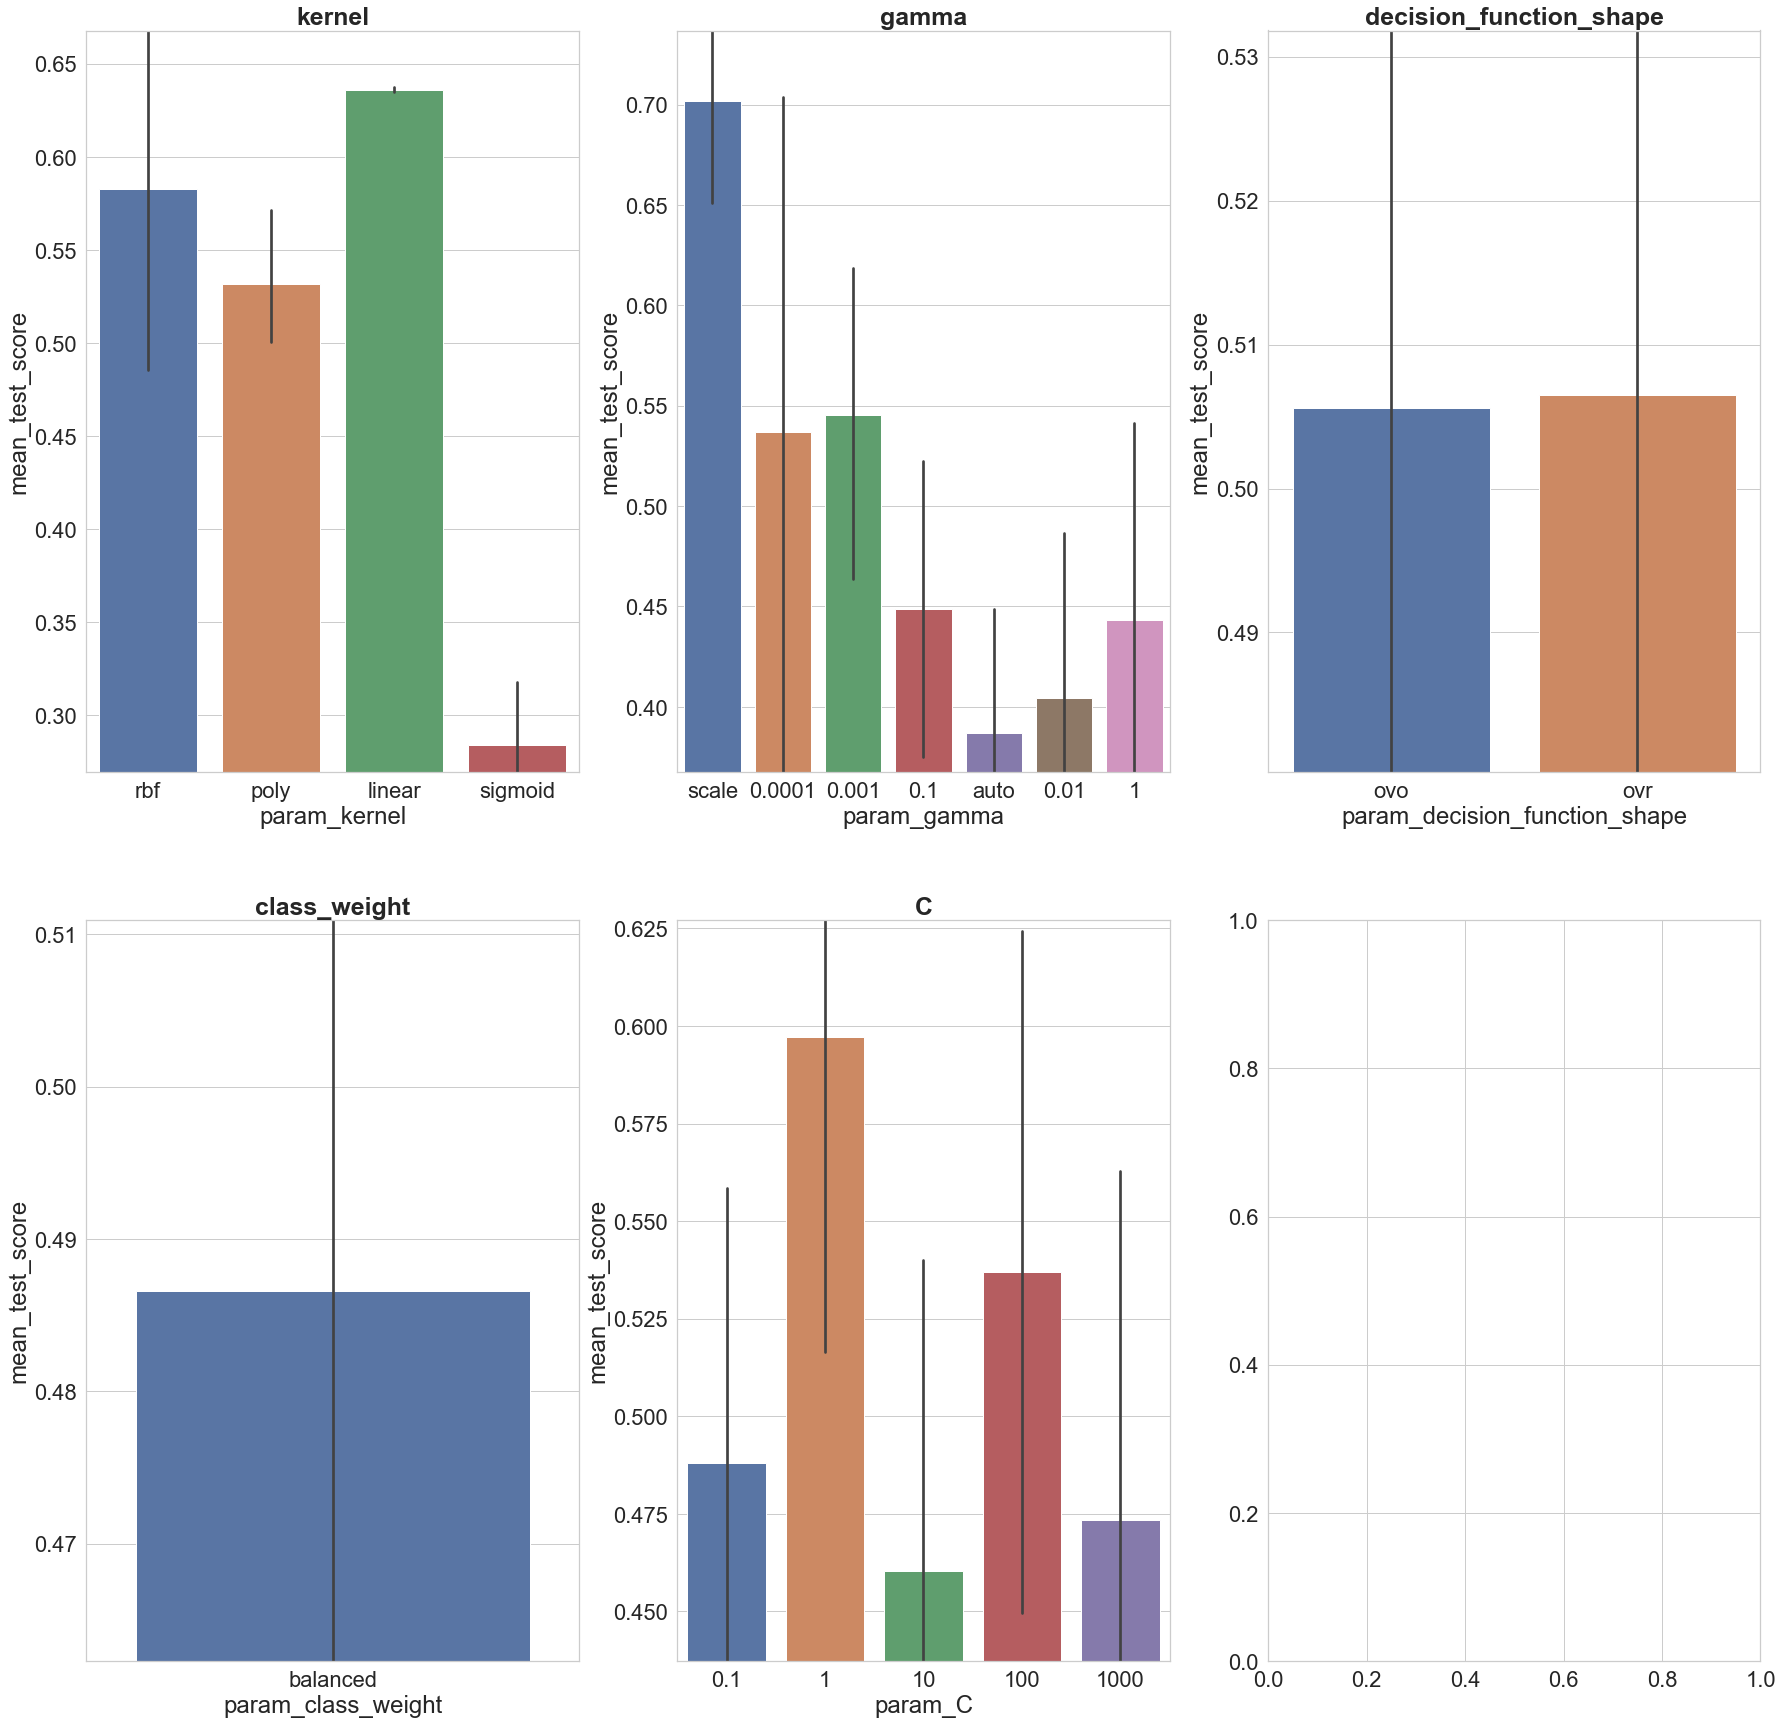

In [62]:
first_round_search(SVC(max_iter=10000), param_grid, 100)

2 раунд

In [63]:
param_grid = {'kernel': ['linear',],
              'C': [1,],
              'gamma': ['scale',],
              'class_weight': [None, 'balanced'],
              'decision_function_shape': ['ovr',]}
param_grid

{'kernel': ['linear'],
 'C': [1],
 'gamma': ['scale'],
 'class_weight': [None, 'balanced'],
 'decision_function_shape': ['ovr']}

In [64]:
grid = GridSearchCV(estimator=SVC(max_iter=10000), param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=1, cv=3)
grid_result = grid.fit(train_x, train_y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    7.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.3s finished
C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [65]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.634511 using {'C': 1, 'class_weight': None, 'decision_function_shape': 'ovr', 'gamma': 'scale', 'kernel': 'linear'}


In [66]:
model_res(grid_result.best_estimator_)

Accuracy:  0.37010159651669083 

Confusion matrix: 
 [[  3   1   3   0]
 [  3  22  32   7]
 [  0 102 221 279]
 [  0   4   3   9]]


C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


### Попробуем обучить нейронные сети

### Сети прямого распространения 

In [71]:
train_y2 = []
for y in train_y:
    y2 = np.zeros(6)
    y2[y] = 1
    train_y2.append(y2)
    
test_y2 = []
for y in test_y:
    y2 = np.zeros(6)
    y2[y] = 1
    test_y2.append(y2)
    
train_y2 = np.array(train_y2)
test_y2 = np.array(test_y2)

In [76]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import make_scorer, accuracy_score
from itertools import combinations

In [85]:
def create_model(neurons1=None, neurons2=None, neurons3=None, activation="relu", optimizer='Adam', loss=keras.losses.MeanSquaredError()):
    model = keras.Sequential()
    if neurons1:
        model.add(Dense(neurons1, activation=activation, kernel_regularizer=keras.regularizers.l2(0.001)))
    if neurons2:
        model.add(Dense(neurons2, activation=activation, kernel_regularizer=keras.regularizers.l2(0.001)))
    if neurons3:
        model.add(Dense(neurons3, activation=activation, kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(6, activation="softmax"))
    model.compile(optimizer=optimizer, 
                  loss=loss,
                  metrics=[keras.metrics.categorical_accuracy]
         )
    return model

In [86]:
def custom_scorer(y_true, y_pred):
    y_true = [np.argmax(y) for y in y_true]
    y_true = np.array(y_true)
    return accuracy_score(y_true, y_pred)
scorer = make_scorer(custom_scorer, greater_is_better=True)

In [87]:
neurons1 = [2**i for i in range(4, 9)]
neurons2 = [2**i for i in range(4, 9)]
neurons3 = [2**i for i in range(4, 9)]
activation = ["relu", "tanh"]
optimizer = ['Adam', 'SGD']
loss = ['mse']
epochs = [20, 50, 100]
batch_size= [5, 10, 15, 20]

param_grid = dict(neurons1=neurons1, 
                  neurons2=neurons2, 
                  neurons3=neurons3, 
                  activation=activation, 
                  optimizer=optimizer,
                  loss=loss,
                  epochs=epochs,
                  batch_size=batch_size)
param_grid

{'neurons1': [16, 32, 64, 128, 256],
 'neurons2': [16, 32, 64, 128, 256],
 'neurons3': [16, 32, 64, 128, 256],
 'activation': ['relu', 'tanh'],
 'optimizer': ['Adam', 'SGD'],
 'loss': ['mse'],
 'epochs': [20, 50, 100],
 'batch_size': [5, 10, 15, 20]}

In [88]:
def first_round_search(est, param_grid, num_iter=100):
    early_stopping = EarlyStopping(monitor='categorical_accuracy', patience=5)
    grid = RandomizedSearchCV(estimator=est,
                               param_distributions=param_grid,
                               n_iter = num_iter,
                               scoring=scorer,
                               verbose=1,
                               cv=3,
                               n_jobs=-1)
    grid_result = grid.fit(train_x, train_y2, callbacks=[early_stopping])
    rs_df = pd.DataFrame(grid_result.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
    rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params',
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
    params_labels = [param for param in rs_df.columns if 'param' in param]
    
    cols = ceil(np.sqrt(len(params_labels)))
    lines = ceil(len(params_labels)/cols)
    fig, axs = plt.subplots(ncols=cols, nrows=lines)
    sns.set(style="whitegrid", color_codes=True, font_scale = 2)
    fig.set_size_inches(30,30)
    
    col = 0
    line = 0
    for param in params_labels:
        sns.barplot(x=param, y='mean_test_score', data=rs_df, ax=axs[line, col])
        axs[line, col].set_ylim([rs_df.groupby(param).mean()['mean_test_score'].min()*0.95,
                                 rs_df.groupby(param).mean()['mean_test_score'].max()*1.05])
        axs[line, col].set_title(label = param.replace('param_', ''), size=25, weight='bold')
        
        if col < cols - 1:
            col += 1
        else:
            line += 1
            col = 0
    

In [101]:
def model_res(est):
    est.fit(train_x, train_y2)
    pred_y = est.predict(test_x)
    cm = confusion_matrix(test_y, pred_y)
    acc = accuracy_score(test_y, pred_y)
    print('Accuracy: ', acc, '\n')
    print('Confusion matrix: \n', cm)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 37.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 61.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 68.5min finished


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

455/455 [==============================] - 1s 2ms/step - loss: 0.1803 - categorical_accuracy: 0.4354
Epoch 2/50
455/455 [==============================] - 0s 939us/step - loss: 0.0926 - categorical_accuracy: 0.7154
Epoch 3/50
455/455 [==============================] - 0s 692us/step - loss: 0.0768 - categorical_accuracy: 0.7684
Epoch 4/50
455/455 [==============================] - 0s 657us/step - loss: 0.0698 - categorical_accuracy: 0.7767
Epoch 5/50
455/455 [==============================] - 

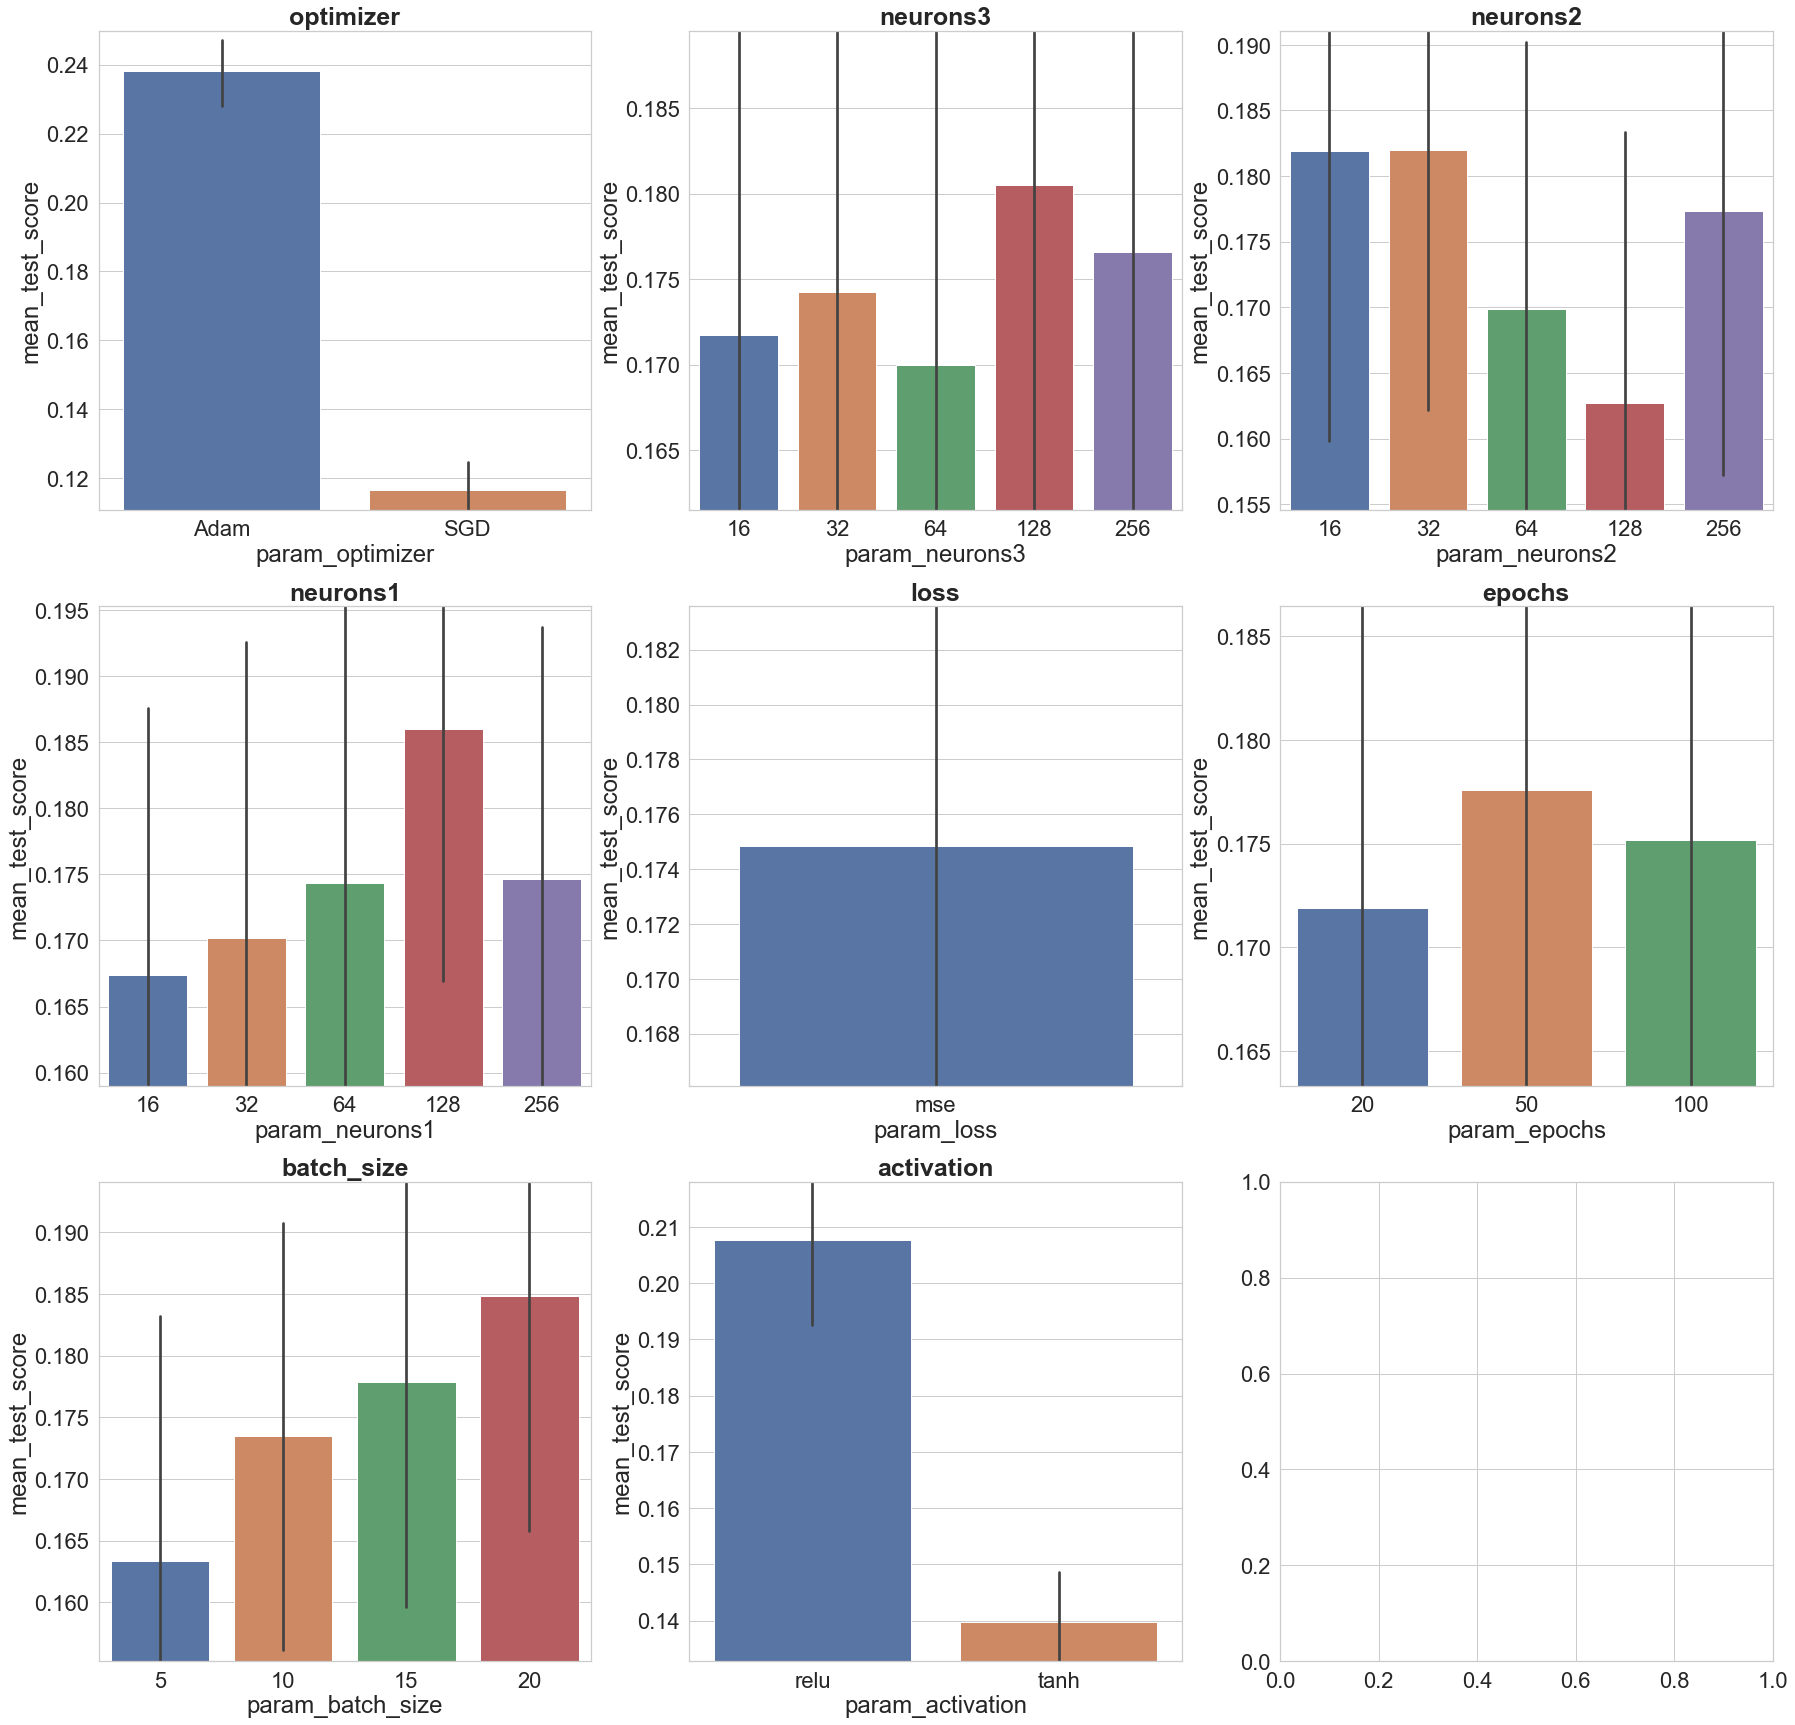

In [90]:
first_round_search(KerasClassifier(build_fn=create_model), param_grid, 300)

In [95]:
neurons1 = [int(x) for x in np.linspace(start = 100, stop = 200, num = 10)]
neurons2 = [int(x) for x in np.linspace(start = 2, stop = 40, num = 10)]
neurons3 = [int(x) for x in np.linspace(start = 100, stop = 200, num = 10)]
activation = ["relu", ]
optimizer = ['Adam', ]
loss = ['mse', ]
epochs = [50, ]
batch_size= [20, ]

param_grid = dict(neurons1=neurons1, 
                  neurons2=neurons2, 
                  neurons3=neurons3, 
                  activation=activation, 
                  optimizer=optimizer,
                  loss=loss,
                  epochs=epochs,
                  batch_size=batch_size)
param_grid

{'neurons1': [100, 111, 122, 133, 144, 155, 166, 177, 188, 200],
 'neurons2': [2, 6, 10, 14, 18, 23, 27, 31, 35, 40],
 'neurons3': [100, 111, 122, 133, 144, 155, 166, 177, 188, 200],
 'activation': ['relu'],
 'optimizer': ['Adam'],
 'loss': ['mse'],
 'epochs': [50],
 'batch_size': [20]}

In [96]:
grid = GridSearchCV(estimator=KerasClassifier(build_fn=create_model), param_grid=param_grid, scoring=scorer, n_jobs=-1, verbose=1, cv=3)
grid_result = grid.fit(train_x, train_y2)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 34.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 62.7min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 100.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 147.2min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 204.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 255.7min finished


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

455/455 [==============================] - 1s 3ms/step - loss: 0.2971 - categorical_accuracy: 0.2767
Epoch 2/50
455/455 [==============================] - 0s 781us/step - loss: 0.2550 - categorical_accuracy: 0.2808
Epoch 3/50
455/455 [==============================] - 0s 951us/step - loss: 0.2478 - categorical_accuracy: 0.2774
Epoch 4/50
455/455 [==============================] - 0s 672us/step - loss: 0.2447 - categorical_accuracy: 0.2808
Epoch 5/50
455/455 [==============================] - 

In [97]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.356508 using {'activation': 'relu', 'batch_size': 20, 'epochs': 50, 'loss': 'mse', 'neurons1': 177, 'neurons2': 40, 'neurons3': 144, 'optimizer': 'Adam'}


In [102]:
model_res(grid_result.best_estimator_)

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

455/455 [==============================] - 0s 723us/step - loss: 0.3064 - categorical_accuracy: 0.2203
Epoch 2/50
455/455 [==============================] - 0s 659us/step - loss: 0.2649 - categorical_accuracy: 0.2215
Epoch 3/50
455/455 [==============================] - 0s 625us/step - loss: 0.1207 - categorical_accuracy: 0.5859
Epoch 4/50
455/455 [==============================] - 0s 634us/step - loss: 0.0538 - categorical_accuracy: 0.7945
Epoch 5/50
455/455 [==============================] 

### Сверточные сети

In [161]:
def create_model(neurons1=None, neurons2=None, neurons3=None, core=3, activation="relu", optimizer='Adam', loss=keras.losses.MeanSquaredError()):
    model = keras.Sequential()
    if neurons1:
        model.add(layers.Conv1D(neurons1, core, activation=activation))
    if neurons2:
        model.add(layers.Conv1D(neurons2, core, activation=activation))
    if neurons3:
        model.add(layers.Conv1D(neurons3, core, activation=activation))
    model.add(layers.Flatten())
    model.add(Dense(6, activation="softmax"))
    model.compile(optimizer=optimizer, 
                  loss=loss,
                  metrics=[keras.metrics.categorical_accuracy]
         )
    return model

In [166]:
neurons1 = [2**i for i in range(6, 9)]
neurons2 = [i for i in range(2, 12)]
neurons3 = [2**i for i in range(6, 9)]
core = [3, 4, 5, 10]
activation = ["relu", "tanh"]
optimizer = ['Adam', 'SGD']
loss = ['mse']
batch_size= [5, 10, 15, 20]

param_grid = dict(neurons1=neurons1, 
                  neurons2=neurons2, 
                  neurons3=neurons3,
                  core=core,
                  activation=activation, 
                  optimizer=optimizer,
                  loss=loss,
                  batch_size=batch_size)
param_grid

{'neurons1': [64, 128, 256],
 'neurons2': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'neurons3': [64, 128, 256],
 'core': [3, 4, 5, 10],
 'activation': ['relu', 'tanh'],
 'optimizer': ['Adam', 'SGD'],
 'loss': ['mse'],
 'batch_size': [5, 10, 15, 20]}

In [108]:
train_x2 = np.array(train_x)
test_x2 = np.array(test_x)
train_x = train_x2.reshape(-1, 66, 1)
test_x = test_x2.reshape(-1, 66, 1)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 30.6min finished


910/910 [==============================] - 3s 3ms/step - loss: 0.0467 - categorical_accuracy: 0.8062


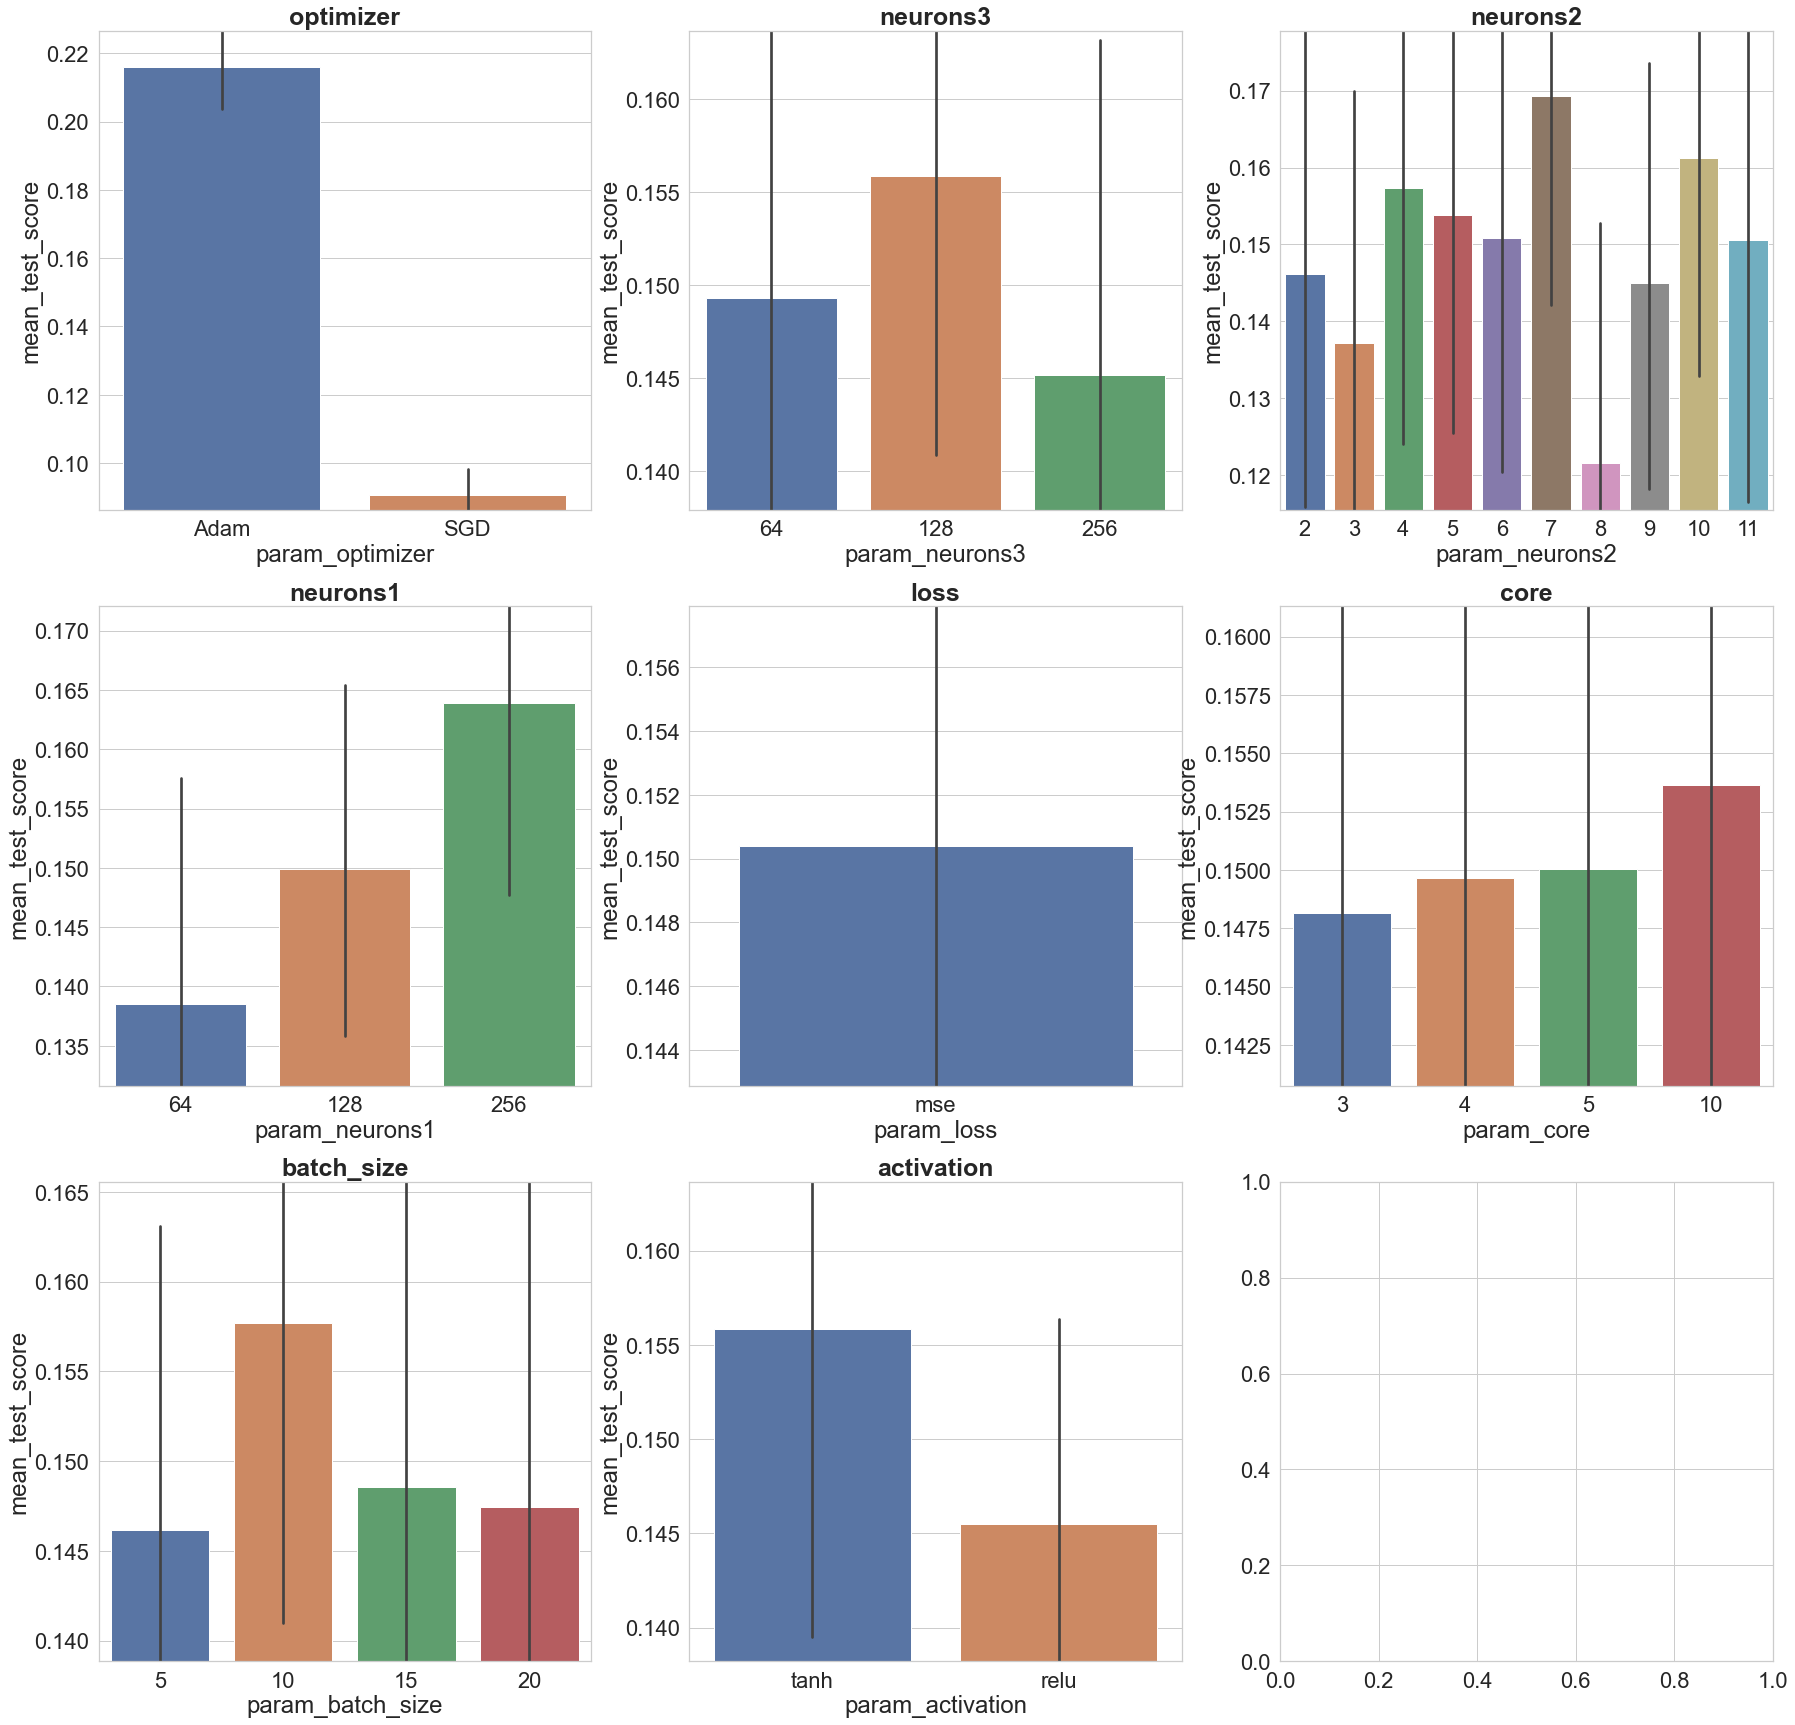

In [164]:
first_round_search(KerasClassifier(build_fn=create_model), param_grid, 300)

In [167]:
neurons1 = [int(x) for x in np.linspace(start = 250, stop = 350, num = 10)]
neurons2 = [7, ]
neurons3 = [int(x) for x in np.linspace(start = 100, stop = 150, num = 10)]
core = [8, 10, 12]
activation = ["tanh",]
optimizer = ['Adam',]
loss = ['mse']
batch_size= [8, 10, 12]

param_grid = dict(neurons1=neurons1, 
                  neurons2=neurons2, 
                  neurons3=neurons3,
                  core=core,
                  activation=activation, 
                  optimizer=optimizer,
                  loss=loss,
                  batch_size=batch_size)
param_grid

{'neurons1': [250, 261, 272, 283, 294, 305, 316, 327, 338, 350],
 'neurons2': [7],
 'neurons3': [100, 105, 111, 116, 122, 127, 133, 138, 144, 150],
 'core': [8, 10, 12],
 'activation': ['tanh'],
 'optimizer': ['Adam'],
 'loss': ['mse'],
 'batch_size': [8, 10, 12]}

In [168]:
grid = GridSearchCV(estimator=KerasClassifier(build_fn=create_model), param_grid=param_grid, scoring=scorer, n_jobs=-1, verbose=1, cv=3)
grid_result = grid.fit(train_x, train_y2)

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 61.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 93.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 130.9min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 172.0min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 191.3min finished


759/759 [==============================] - 8s 10ms/step - loss: 0.0568 - categorical_accuracy: 0.7634


In [169]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.323756 using {'activation': 'tanh', 'batch_size': 12, 'core': 8, 'loss': 'mse', 'neurons1': 261, 'neurons2': 7, 'neurons3': 116, 'optimizer': 'Adam'}


In [170]:
model_res(grid_result.best_estimator_)

759/759 [==============================] - 5s 7ms/step - loss: 0.0581 - categorical_accuracy: 0.7635
Accuracy:  0.8693759071117562 

Confusion matrix: 
 [[  4   0   3   0]
 [ 12   0  52   0]
 [  7   0 595   0]
 [  0   0  16   0]]


## Попробуем обучить модели на сгенерированных данных (комбинации предложений)

In [214]:
class Results:
    def __init__(self, train_data, test_x, test_y):
        self.texts = train_data['text'].copy()
        self.train_y = train_data['cls'].copy()
        self.feature_columns = [col for col in df_gen.columns if col not in ['cls', 'text']]
        self.train_x = train_data[self.feature_columns].copy()
        self.test_x = test_x
        self.test_y = test_y
    
    def show_train_data(self):
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(10,8)
        plt.tick_params(labelsize=15)
        
        ax = sns.countplot(x='cls', data=pd.DataFrame(self.train_y), palette="Set2")
        ax.set_xlabel('Классы', {'fontsize': 15})
        ax.set_ylabel('Кол-во текстов', {'fontsize': 15})
        ax.grid(True)
        ax.set_title('Распределение классов', {'fontsize': 20})
        
        plt.show()
    
    # Добавить модель к классу
    # (модель, сетка для 1 раунда, сетка для 2 раунда)
    def add_est(self,
                name,
                est):
        setattr(self, 'est_{}'.format(name), {'est': est})
        
    # Установить параметр модели
    def set_est_param(self, est_name, param_name, param_value):
        dummy = getattr(self, 'est_{}'.format(est_name))
        dummy[param_name] = param_value
        setattr(self, 'est_{}'.format(est_name), dummy)
    
    def set_est_param_grid_1(self, est_name, param_grid_1):
        self.set_est_param(est_name, 'param_grid_1', param_grid_1)
        
    def set_est_param_grid_2(self, est_name, param_grid_2):
        self.set_est_param(est_name, 'param_grid_2', param_grid_2)
    
    def get_est_info(self, est_name):
        dummy = getattr(self, 'est_{}'.format(est_name))
        for key in dummy:
            print('{0}: {1}'.format(key, dummy.get(key)))
    
    # Получить список имен моделей
    def get_est_list(self):
        res = []
        for key in self.__dict__.keys():
            if key.startswith('est_'):
                res.append(key.replace('est_', ''))
        return res
        
        
    # Первый раунд обучения модели
    def first_round_search(self, est_name, num_iter=100, cv=3):
        est = getattr(self, 'est_{}'.format(est_name)).get('est')
        param_grid = getattr(self, 'est_{}'.format(est_name)).get('param_grid_1')
        
        grid = RandomizedSearchCV(estimator=est,
                          param_distributions=param_grid,
                          n_iter = num_iter,
                          scoring='accuracy',
                          n_jobs=-1,
                          verbose=1,
                          cv=cv,
                          random_state=SEED)
        grid_result = grid.fit(self.train_x, self.train_y)
        rs_df = pd.DataFrame(grid_result.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
        rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params',
            'std_test_score'],
            axis=1)
        params_labels = [param for param in rs_df.columns if 'param' in param]
    
        cols = ceil(np.sqrt(len(params_labels)))
        lines = ceil(len(params_labels)/cols)
        fig, axs = plt.subplots(ncols=cols, nrows=lines)
        sns.set(style="whitegrid", color_codes=True, font_scale = 2)
        fig.set_size_inches(30,30)
    
        col = 0
        line = 0
        for param in params_labels:
            sns.barplot(x=param, y='mean_test_score', data=rs_df, ax=axs[line, col])
            axs[line, col].set_ylim([rs_df.groupby(param).mean()['mean_test_score'].min()*0.95,
                                 rs_df.groupby(param).mean()['mean_test_score'].max()*1.05])
            axs[line, col].set_title(label = param.replace('param_', ''), size=25, weight='bold')
        
            if col < cols - 1:
                col += 1
            else:
                line += 1
                col = 0
    
    # Второй раунд обучения
    def second_round_search(self, est_name, cv=3):
        est = getattr(self, 'est_{}'.format(est_name)).get('est')
        param_grid = getattr(self, 'est_{}'.format(est_name)).get('param_grid_2')
        
        grid = GridSearchCV(estimator=est,
                            param_grid=param_grid,
                            scoring='accuracy',
                            n_jobs=-1,
                            verbose=1,
                            cv=cv)
        grid_result = grid.fit(self.train_x, self.train_y)
        
        self.set_est_param(est_name, 'train_acc', grid_result.best_score_)
        self.set_est_param(est_name, 'best_params', grid_result.best_params_)
        self.set_est_param(est_name, 'best_est', grid_result.best_estimator_)
        
        (test_acc, cm, pred_y) = self.est_res(est_name)
        self.set_est_param(est_name, 'test_acc', test_acc)
        self.set_est_param(est_name, 'confusion_matrix', cm)
        self.set_est_param(est_name, '{}_pred_y'.format(est_name), pred_y)
    
    def est_res(self, est_name):
        est = getattr(self, 'est_{}'.format(est_name)).get('best_est')
        
        pred_y = est.predict(self.test_x)
        cm = confusion_matrix(self.test_y, pred_y)
        acc = accuracy_score(self.test_y, pred_y)
        
        print('Accuracy: ', acc, '\n')
        print('Confusion matrix: \n', cm)
        
        return acc, cm, pred_y
    
    def get_result_df(self):
        res = pd.DataFrame(self.test_y)
        res.rename(columns={'cls': 'real_y'}, inplace=True)
        
        for est_name in self.get_est_list():
            res['{}_y'.format(est_name)] = getattr(self, 'est_{}'.format(est_name)).get('{}_pred_y'.format(est_name))
        return res

In [159]:
df_gen = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\generated_data_sent.csv', index_col='idx')
df_gen.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_pres_plur,num_past_part,num_past_simple,num_linkings,num_4grams,num_func_ngrams,sum_punct,million_mistake,text,cls
idx,,,,,,,,,,,,,,,,,,,,,
0,8.5,12,5,3,3,2,2,109,10.0,54.5,...,0,2,2,5,1,0,0,0,"First of all, many contries have only idea of ...",2
1,9.5,11,8,1,4,6,2,105,3.5,52.5,...,0,4,3,5,3,0,2,0,A lot of common people do not understand their...,2


Т.к. сгенерированны данные только для тренировочной выборки, то тестовую выборку получим из начальных данных

In [160]:
df = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\classification_dataset.csv')
df.drop(['num_misspelled_tokens', 'num_shell_noun', 'name', 'type', 'punct_mistakes_pp', 'punct_mistakes_because', 'punct_mistakes_but', 'punct_mistakes_compare', 'side_mistake', 'text'],  inplace=True, axis=1)
df['class'] = round(df['class'] / 10).astype(int)
df.loc[df['class'] == 1, 'class'] = 2
df.loc[df['class'] == 3, 'class'] = 2
df.loc[df['class'] == 4, 'class'] = 3
df.loc[df['class'] == 5, 'class'] = 3
df.loc[df['class'] == 6, 'class'] = 4
df.loc[df['class'] == 7, 'class'] = 4
df.loc[df['class'] == 8, 'class'] = 5

df = df.rename(columns = {'class': 'cls'})
feature_columns = [col for col in df.columns if col not in ['cls',]]
X = df[feature_columns]
y = df['cls']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state = SEED)

In [215]:
res = Results(df_gen,
              test_x,
              test_y)

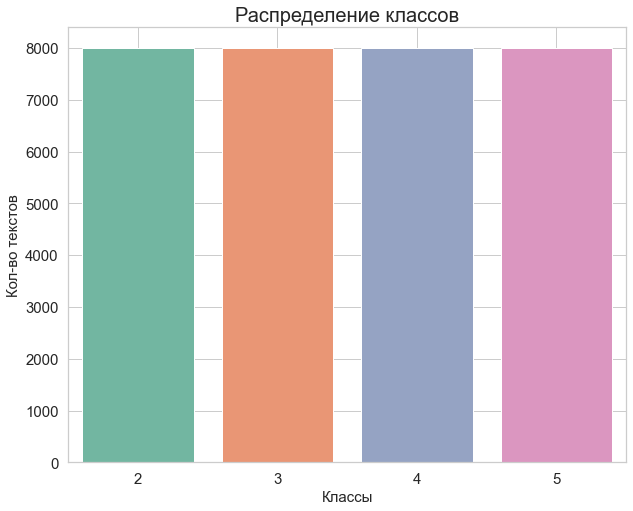

In [216]:
res.show_train_data()

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   14.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   16.2s finished


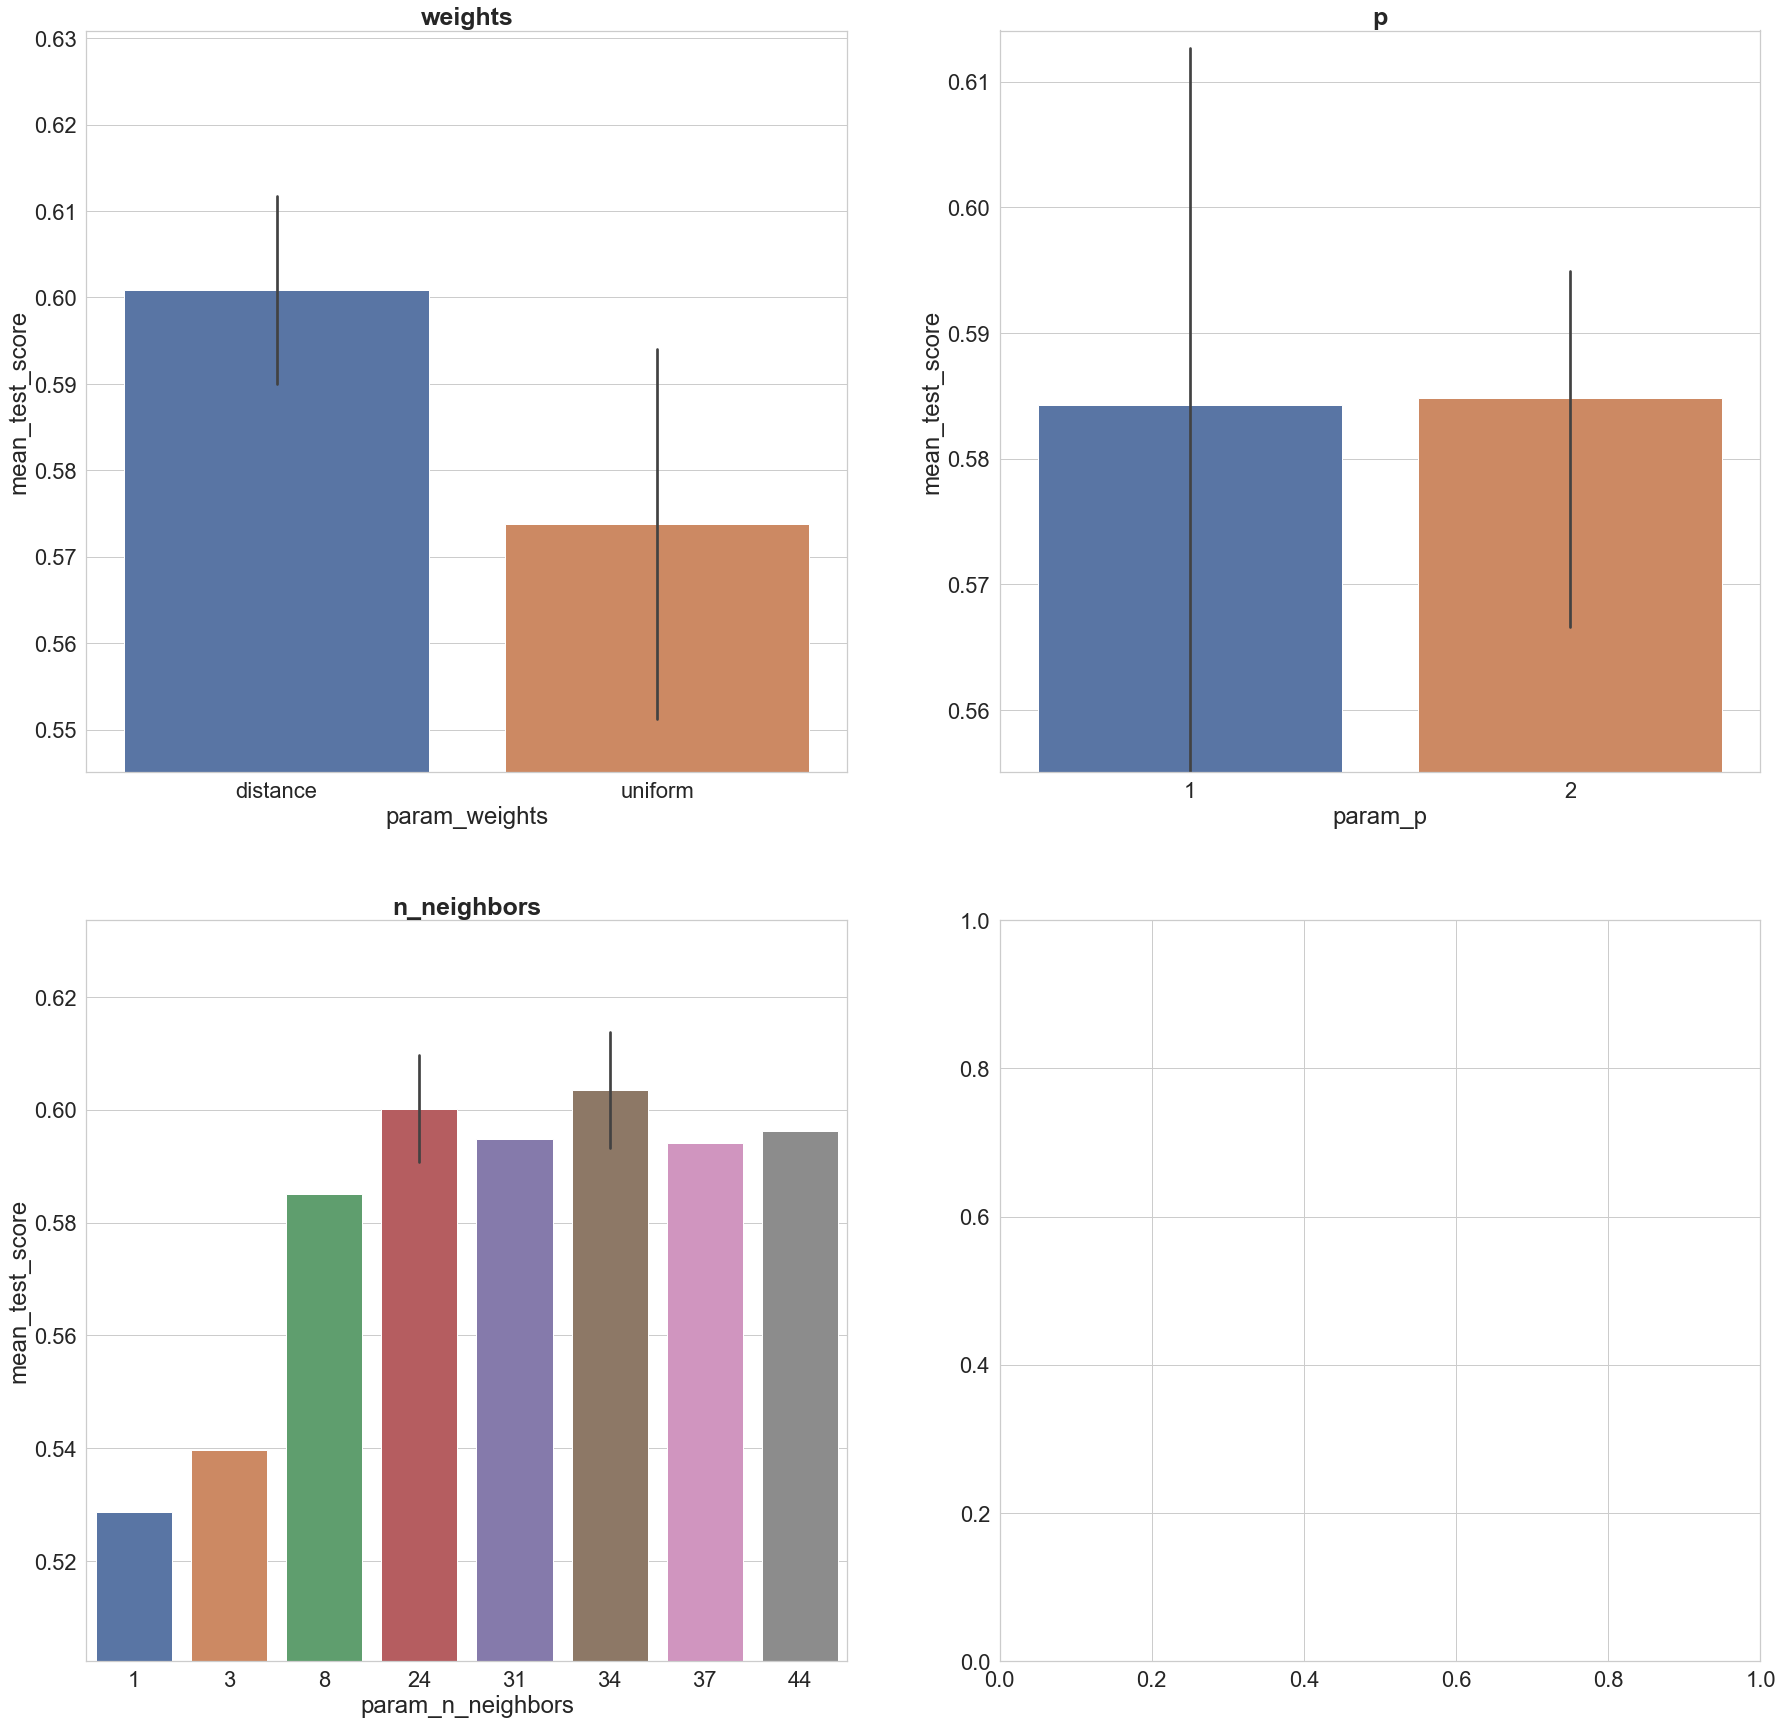

In [217]:
knn_param_grid_1 = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 50, num = 20)],
              'p': [1, 2],
              'weights': ['uniform', 'distance']}

res.add_est('knn', KNeighborsClassifier(metric='minkowski', algorithm='auto'))
res.set_est_param_grid_1('knn', knn_param_grid_1)

res.first_round_search('knn', 10, 2)

In [218]:
knn_param_grid_2 = {'n_neighbors': [38, 39, 40, 41],
              'p': [1,],
              'weights': ['distance',]}

res.set_est_param_grid_2('knn', knn_param_grid_2)

In [219]:
res.second_round_search('knn', 2)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   12.0s remaining:   20.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   12.9s finished


Accuracy:  0.17561683599419448 

Confusion matrix: 
 [[  2   5   0   0]
 [ 22  27   5  10]
 [ 42 265  86 209]
 [  0  10   0   6]]


In [227]:
pd.options.display.max_rows = 20

In [228]:
a = res.get_result_df()
a

,real_y,knn_y
265,4,5
1010,4,3
3212,4,4
579,4,3
1665,4,4
...,...,...
3079,3,3
3102,4,3
207,4,3
1643,3,5


In [2]:
df_gen = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\generated_data_sent.csv', index_col='idx')
df_gen.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_pres_sing,num_pres_plur,num_past_part,num_past_simple,num_linkings,num_4grams,num_func_ngrams,sum_punct,million_mistake,cls
idx,,,,,,,,,,,,,,,,,,,,,
0,8.5,12,5,3,3,2,2,109,10.0,54.5,...,2,0,2,2,5,1,0,0,0,2
1,9.5,11,8,1,4,6,2,105,3.5,52.5,...,3,0,4,3,5,3,0,2,0,2


In [3]:
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32000 entries, 0 to 31999
Data columns (total 67 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   av_depth            32000 non-null  float64
 1   max_depth           32000 non-null  int64  
 2   min_depth           32000 non-null  int64  
 3   num_acl             32000 non-null  int64  
 4   num_rel_cl          32000 non-null  int64  
 5   num_advcl           32000 non-null  int64  
 6   num_sent            32000 non-null  int64  
 7   num_tok             32000 non-null  int64  
 8   av_tok_before_root  32000 non-null  float64
 9   av_len_sent         32000 non-null  float64
 10  num_cl              32000 non-null  int64  
 11  num_tu              32000 non-null  int64  
 12  num_compl_tu        32000 non-null  int64  
 13  num_coord           32000 non-null  int64  
 14  num_poss            32000 non-null  int64  
 15  num_prep            32000 non-null  int64  
 16  num_

In [4]:
df_gen['cls'].value_counts()

5    8000
4    8000
3    8000
2    8000
Name: cls, dtype: int64

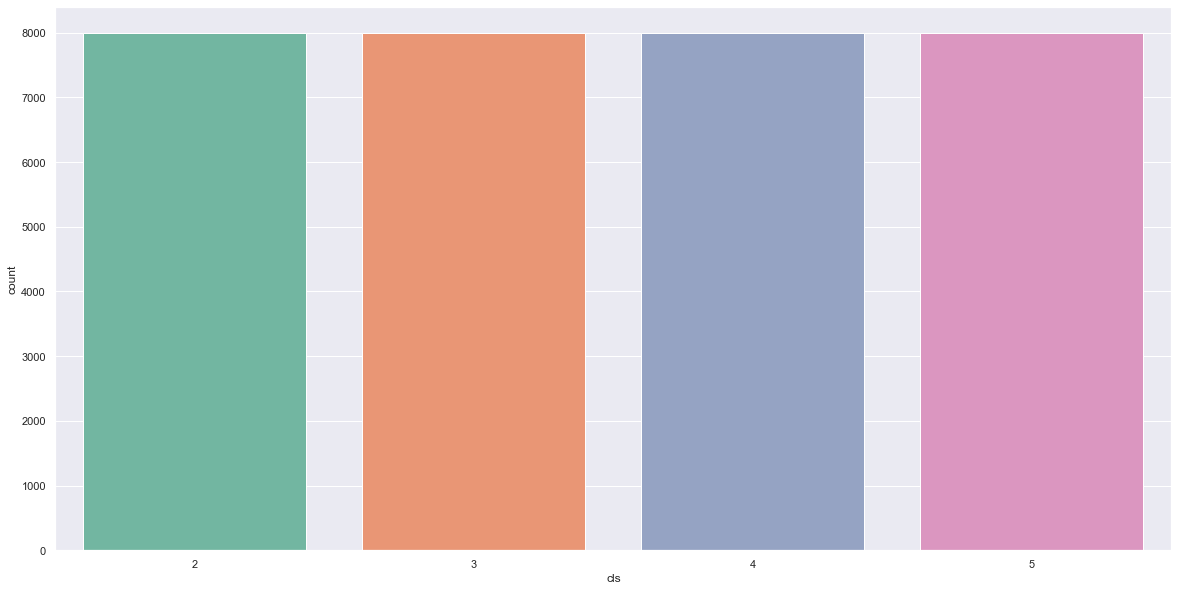

In [5]:
sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='cls', data=df_gen, palette="Set2")

Т.к. сгенерированны данные только для тренировочной выборки, то тестовую выборку получим из начальных данных

In [6]:
df = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\classification_dataset.csv')
df.drop(['num_misspelled_tokens', 'num_shell_noun', 'name', 'type', 'punct_mistakes_pp', 'punct_mistakes_because', 'punct_mistakes_but', 'punct_mistakes_compare', 'side_mistake', 'text'],  inplace=True, axis=1)
df['class'] = round(df['class'] / 10).astype(int)
df.loc[df['class'] == 1, 'class'] = 2
df.loc[df['class'] == 3, 'class'] = 2
df.loc[df['class'] == 4, 'class'] = 3
df.loc[df['class'] == 5, 'class'] = 3
df.loc[df['class'] == 6, 'class'] = 4
df.loc[df['class'] == 7, 'class'] = 4
df.loc[df['class'] == 8, 'class'] = 5

df = df.rename(columns = {'class': 'cls'})
feature_columns = [col for col in df.columns if col not in ['cls',]]
X = df[feature_columns]
y = df['cls']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state = SEED)

In [7]:
feature_columns = [col for col in df_gen.columns if col not in ['cls',]]
train_x = df_gen[feature_columns]
train_y = df_gen['cls']

### KNN

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
param_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 50, num = 20)],
              'p': [1, 2],
              'weights': ['uniform', 'distance']}
param_grid

{'n_neighbors': [1,
  3,
  6,
  8,
  11,
  13,
  16,
  19,
  21,
  24,
  26,
  29,
  31,
  34,
  37,
  39,
  42,
  44,
  47,
  50],
 'p': [1, 2],
 'weights': ['uniform', 'distance']}

1 раунд

C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.3min finished


(0.6202500598070448,
 {'weights': 'distance', 'p': 1, 'n_neighbors': 39},
 KNeighborsClassifier(n_neighbors=39, p=1, weights='distance'))

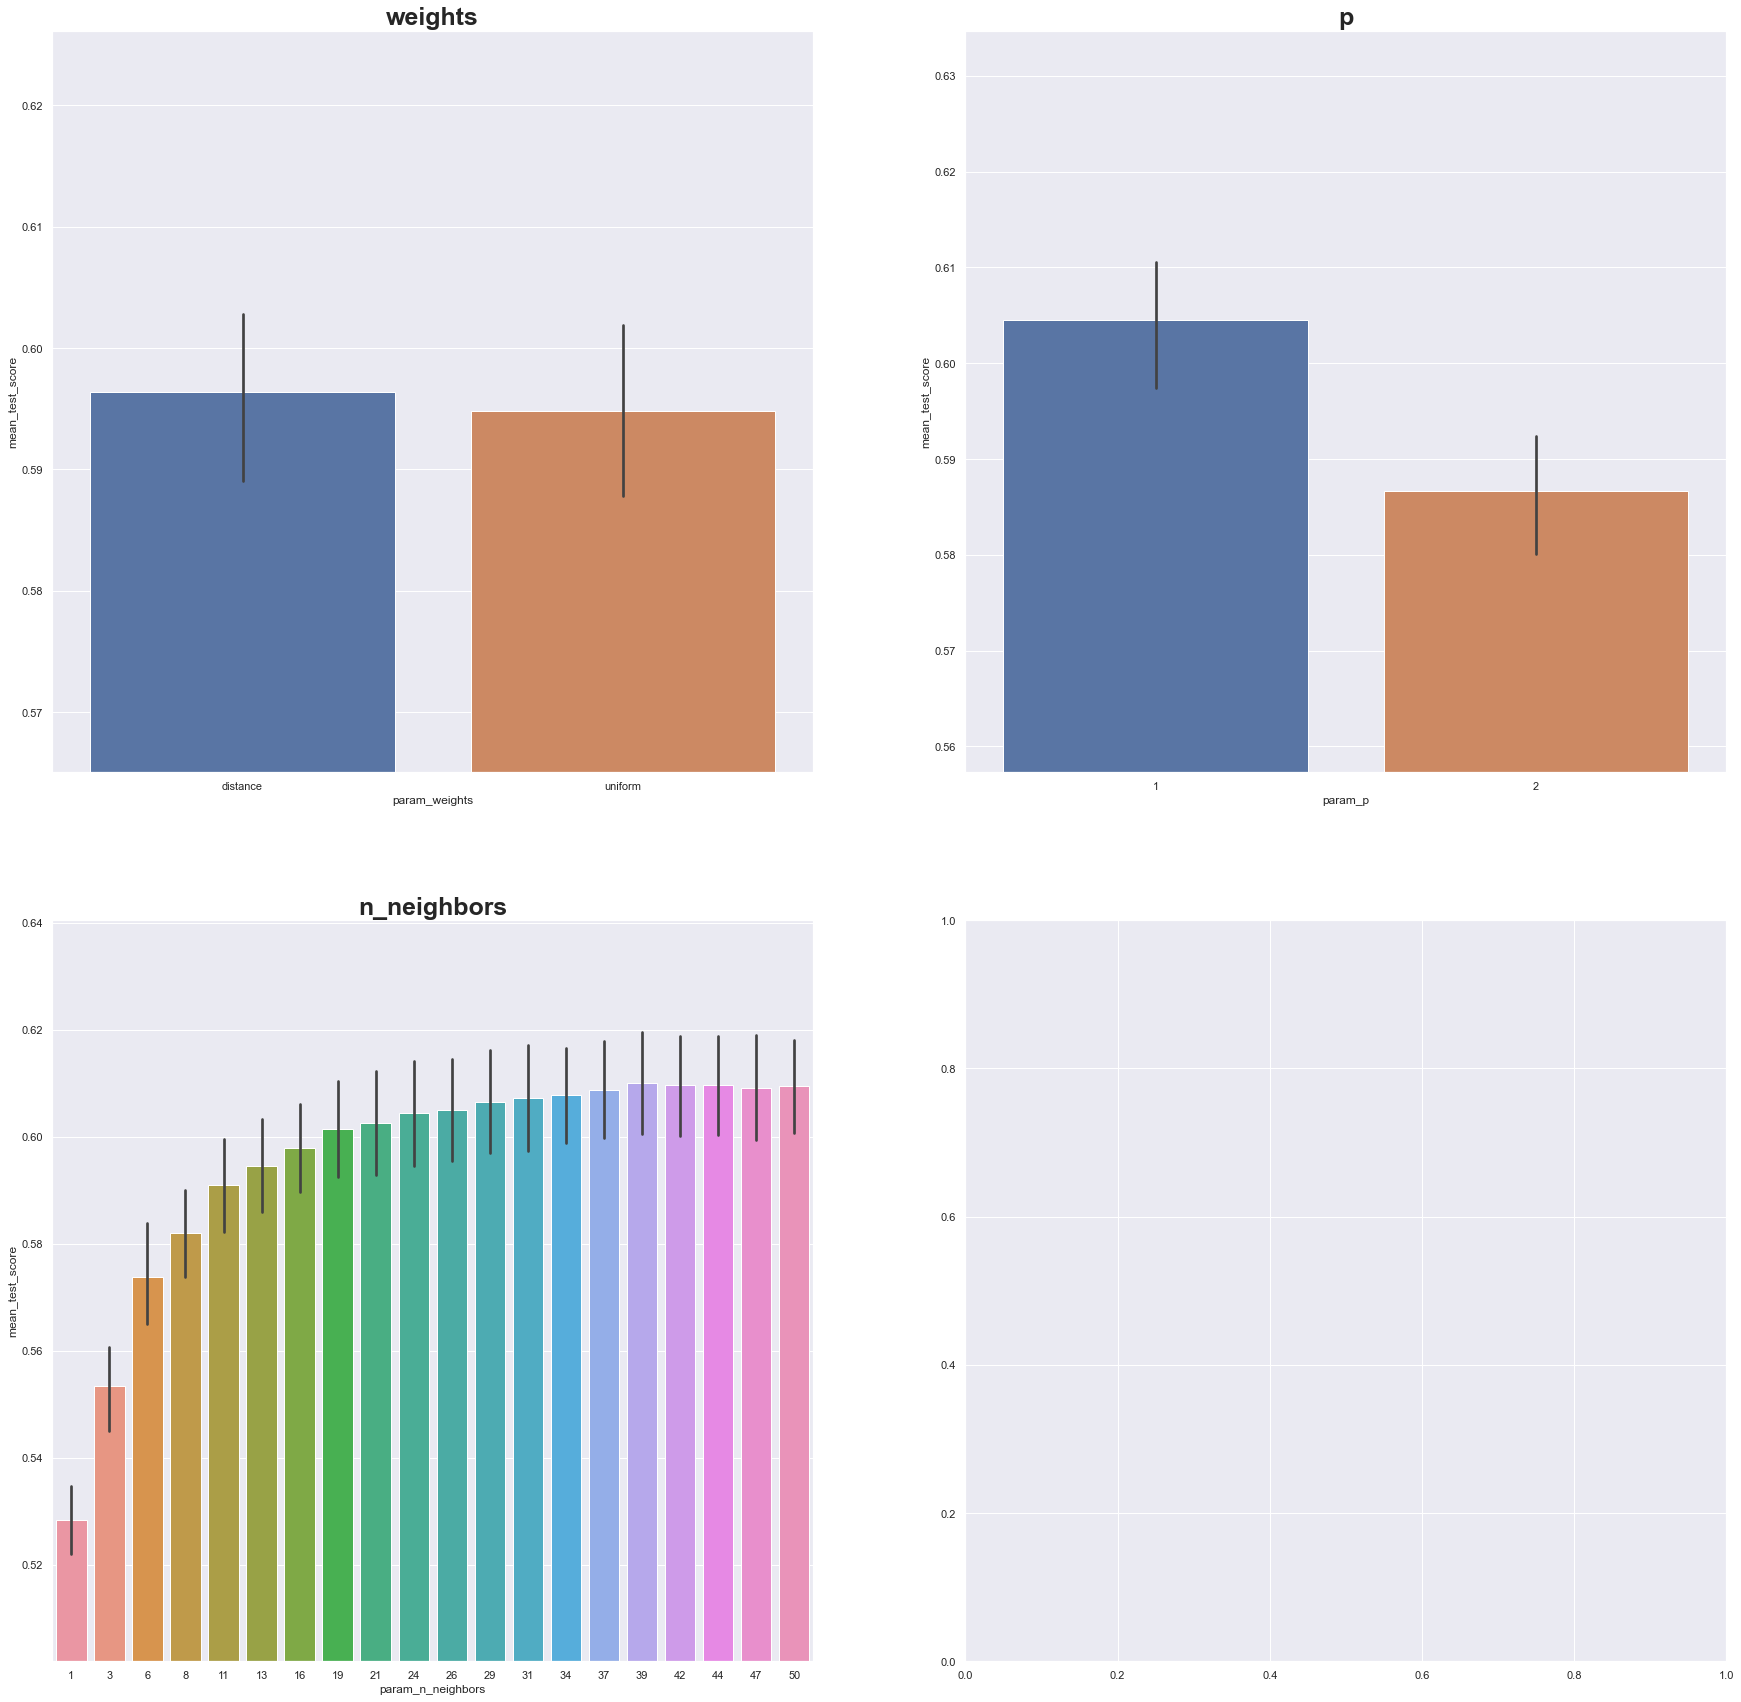

In [13]:
first_round_search(KNeighborsClassifier(metric='minkowski', algorithm='auto'), param_grid, 100)

2 раунд

In [14]:
param_grid = {'n_neighbors': [38, 39, 40, 41],
              'p': [1,],
              'weights': ['distance',]}
param_grid

{'n_neighbors': [38, 39, 40, 41], 'p': [1], 'weights': ['distance']}

In [15]:
grid = GridSearchCV(estimator=KNeighborsClassifier(metric='minkowski', algorithm='auto'), param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=1, cv=3)
grid_result = grid.fit(train_x, train_y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:   17.5s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   18.5s finished


In [16]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.620250 using {'n_neighbors': 39, 'p': 1, 'weights': 'distance'}


In [17]:
model_res(grid_result.best_estimator_)

Accuracy:  0.18287373004354138 

Confusion matrix: 
 [[  2   5   0   0]
 [ 22  27   6   9]
 [ 41 265  91 205]
 [  0  10   0   6]]


### RandomForest

In [18]:
from sklearn.ensemble import RandomForestClassifier

1 раунд

In [19]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
              'max_features': ['auto', 'log2', 'sqrt'],
              'max_depth': [1, 5, 10, 15, 20, 30],
              'min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
              'min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 80, num = 15)],
              'bootstrap': [True, False]}
param_grid

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'max_features': ['auto', 'log2', 'sqrt'],
 'max_depth': [1, 5, 10, 15, 20, 30],
 'min_samples_split': [2, 7, 12, 18, 23, 28, 34, 39, 44, 50],
 'min_samples_leaf': [2,
  7,
  13,
  18,
  24,
  29,
  35,
  41,
  46,
  52,
  57,
  63,
  68,
  74,
  80],
 'bootstrap': [True, False]}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.6min finished


(0.7204998890990731,
 {'n_estimators': 800,
  'min_samples_split': 18,
  'min_samples_leaf': 2,
  'max_features': 'log2',
  'max_depth': 20,
  'bootstrap': False},
 RandomForestClassifier(bootstrap=False, max_depth=20, max_features='log2',
                        min_samples_leaf=2, min_samples_split=18,
                        n_estimators=800))

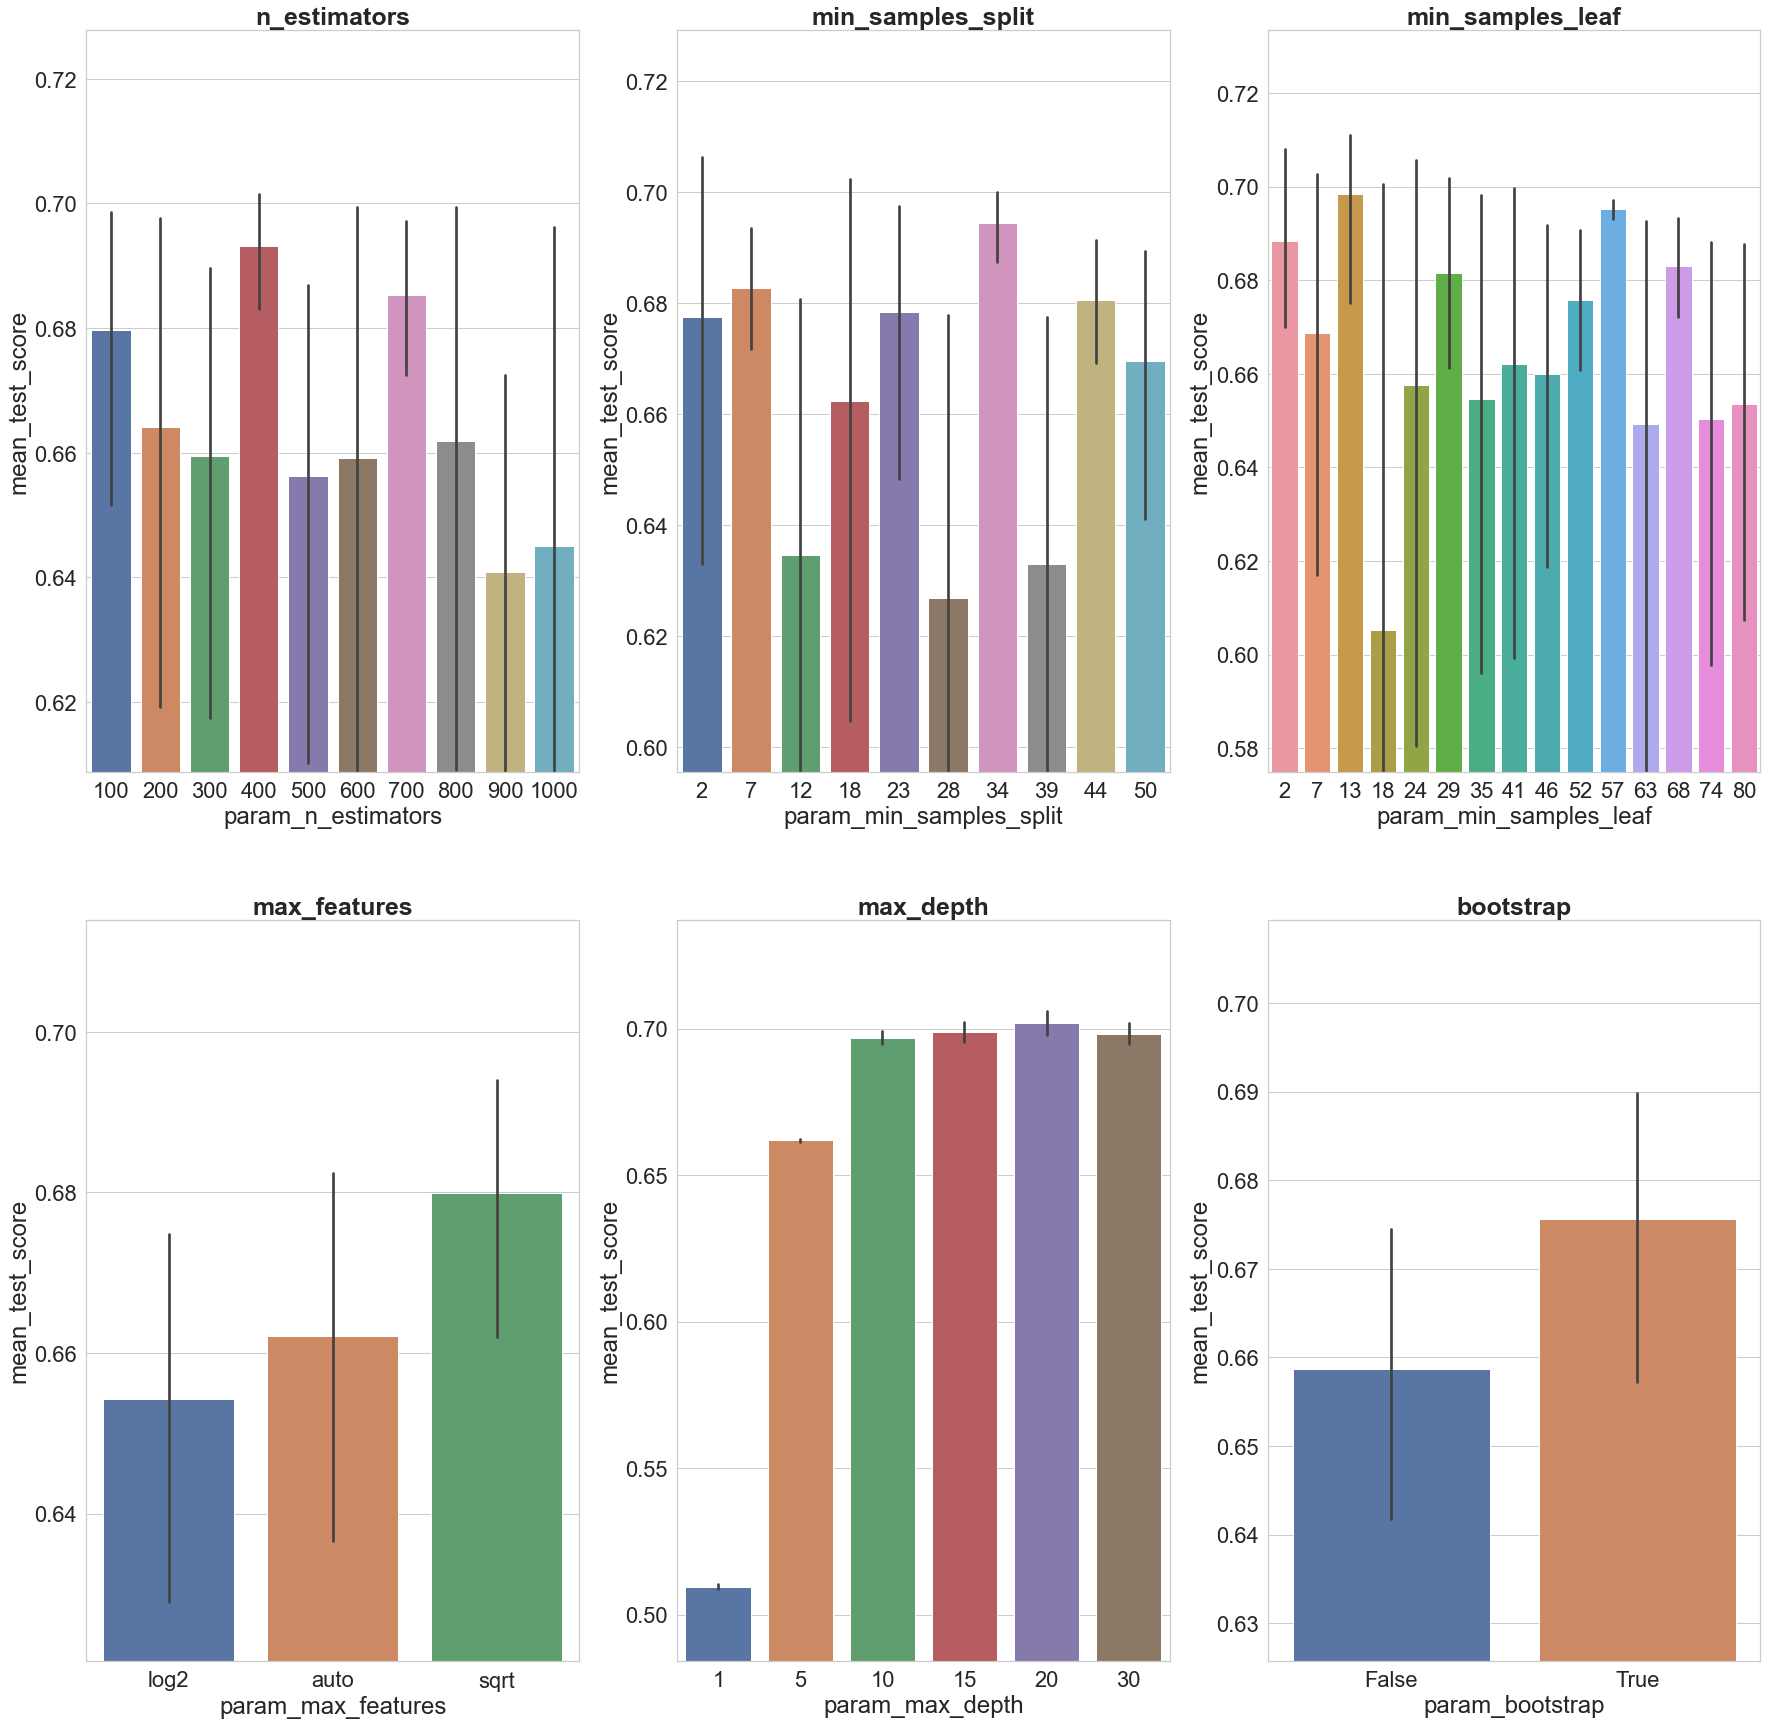

In [20]:
first_round_search(RandomForestClassifier(), param_grid, 100)

2 раунд

In [21]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 380, stop = 420, num = 10)],
              'max_features': ['sqrt',],
              'max_depth': [18, 19, 20, 21, 22],
              'min_samples_split': [29, 31, 33, 34, 35, 37],
              'min_samples_leaf': [11, 12, 13, 14, 15],
              'bootstrap': [True, ]}
param_grid

{'n_estimators': [380, 384, 388, 393, 397, 402, 406, 411, 415, 420],
 'max_features': ['sqrt'],
 'max_depth': [18, 19, 20, 21, 22],
 'min_samples_split': [29, 31, 33, 34, 35, 37],
 'min_samples_leaf': [11, 12, 13, 14, 15],
 'bootstrap': [True]}

In [22]:
grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=1, cv=3)
grid_result = grid.fit(train_x, train_y)

Fitting 3 folds for each of 1500 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 21.0min


KeyboardInterrupt: 

In [41]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.861988 using {'bootstrap': True, 'max_depth': 21, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 29, 'n_estimators': 397}


In [42]:
model_res(grid_result.best_estimator_)

Accuracy:  0.8824383164005806 

Confusion matrix: 
 [[  2   1   4   0]
 [  4  13  47   0]
 [  0   7 593   2]
 [  0   0  16   0]]
